In [1]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
###############################################################

# From Butler, O'Dwyer (2018)

In [2]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=7)

np.random.seed(999)

In [3]:
mpl.rcParams['figure.dpi'] = 125
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})

# O'Dwyer Model

## Original P functions

In [4]:
## Asymmetric P matrix ##
def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### half-normal entries

In [5]:
## Symmetric P matrix ##
def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

## Vectorized P functions

In [6]:
### Vectorized Asymmetric P matrix
def asymPvec(sig, n, k=1):
    return abs(normal(0, sig, (k, n, n))) # again, a half-normal with mean=1

In [7]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [8]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

## Eigenvalues, single fixed P

In [9]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P, sP, and an asymmetric P, aP.
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        #mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s at each P, append eigenvalues

sev = np.array([])
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vectors
                                                # produces this equilibrium


for k in range(5000): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n)) # DON'T REEVALUATE EVERY ITERATION

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

In [10]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [11]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

### Eigenvalue hexbin plots

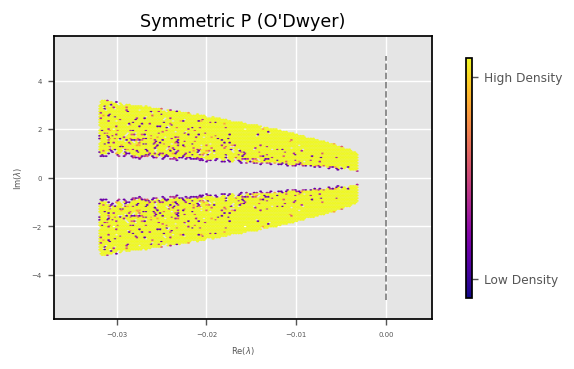

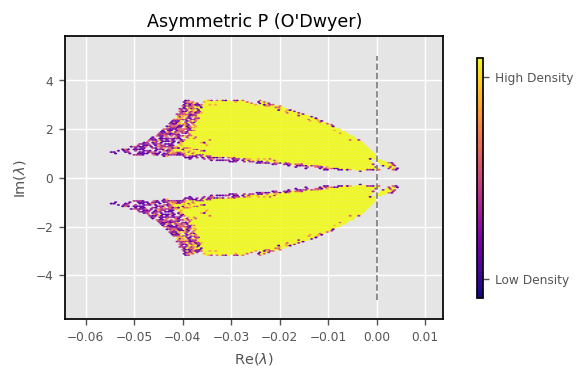

In [12]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (5,3))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white', alpha = 0) 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 7}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)
        plt.title('Symmetric P (O\'Dwyer)')
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        plt.title('Asymmetric P (O\'Dwyer)')        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

## Old O'Dwyer Stuff

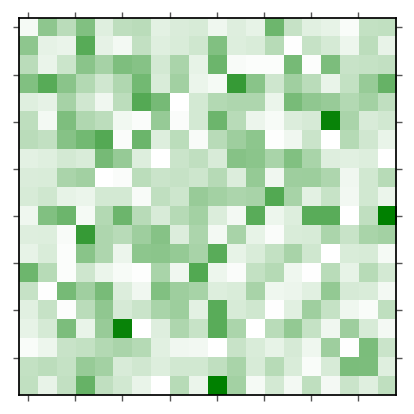

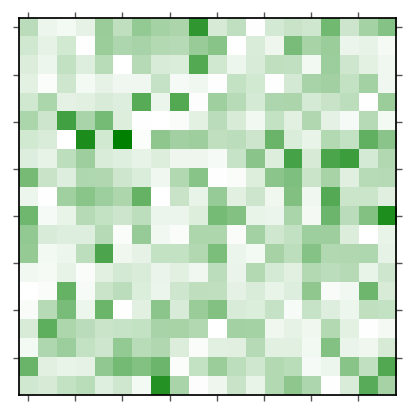

In [13]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

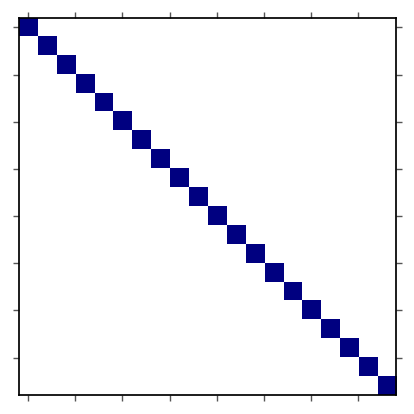

In [14]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


## Frequency of stable n-size systems

In [15]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []

## Parameters ##
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat
    I = np.identity(nn)

    ## Consumption Matrix ##
    C = c * I

    ## Production matrices ##
    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Equilibrium Abundances ##
        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

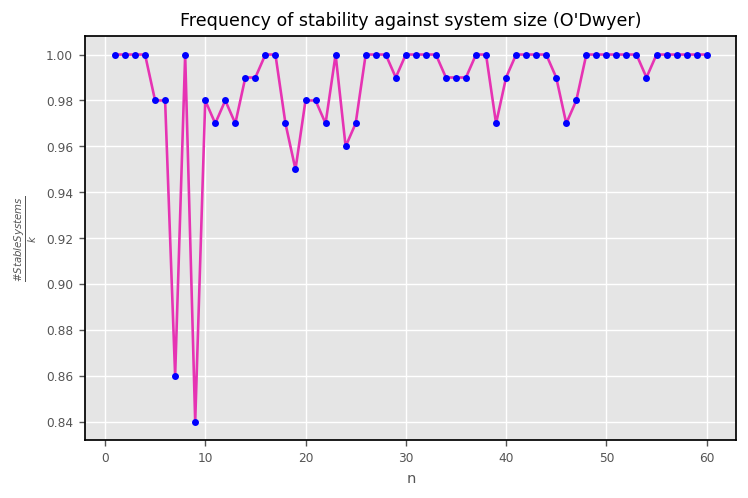

In [16]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();

# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable.

In [17]:
x_data[np.argmin(y_data)] # Least chance of having stable system at n=9

9

# 'Random P and Corresponding Equilibria' Approach

In [18]:
###############################################################################
# Instead, consider randomizing the (n,n) P(roduction matrix) and eval'ing its Jacobian only at 
    # the corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 R_stars)
# ""                 (5000 S_stars)
###############################################################################

## Setup for new approach

In [19]:
def extract_block_diags(A_,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    Previously needed for S_star_gen()

    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A_,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A_.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]

In [20]:
### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, the formulae below will produce feasible Steady States

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

In [21]:
# Why are r_i values as big as 100??? Any way to normalize/nondimensionalize the model?

def R_star_gen(C_,P_,eps_,mu_): # P_ is actually 3-dimensional matrix (k nxn sub-P-matrices)
    '''
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of 'P_' argument.
    '''
    k_ = P_.shape[0]
    n_ = P_.shape[-1]
    # mu_ = np.tile(mu_,(k_,1,1))
    
    A_ = np.linalg.inv(C_.T)*(1/eps_) # A is just (k_,n_,n_)
    # print('P:',P.shape)
    # print('mu:',mu.shape)
    # print('k:',k_)
    # print('n:',n_)
    v_ = np.sum(np.transpose(P_,(0,2,1)), 2).reshape(k_,n_,1) + mu_.reshape(1,n_,1) #take row sums of P_ transpose, reshape to add 
    #v = np.sum(np.transpose(P_,(0,2,1)), 2).reshape(k_,n_,1) + mu_
    
    R_star_ = np.tensordot(A_,v_,axes=([1],[1]))
    R_star_ = R_star_.reshape(n_,k_).T.reshape(k_,n_,1)
    return R_star_

In [23]:
# ### Resource-Competition Steady State vectors (R_star and S_star)
# # Why are Rstars in the range of r_i in [1,100]??? Any way to normalize/nondimensionalize the model?

# def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
#     '''
#     Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
#     that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
#     No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
#     '''
    
#     k = P.shape[0]
#     n = P.shape[-1]
#     mu = np.tile(mu,(k,1,1))
    
#     #C = np.tile(C,(k,1,1)) # OLD: stack C k times so that it can be dotted with each sub-Ps
#                                 # np.dot() does not broadcast, I think. Have to manually add 3rd dimension
#     #A = np.linalg.inv(np.transpose(C,(0,2,1)))*(1/eps) # split up into A,v for readability
#     A = np.linalg.inv(C.T)*(1/eps) # A is just (k,n,n)
#     v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
#     # How to pairwise dot an array of 2D matrices with array of column vectors?
    
#     R_star = np.tensordot(A,v,axes=([1],[1]))
#     R_star = R_star.reshape(n,k).T.reshape(k,n,1)
#     #np.tensordot(I,b,axes=([1],[1])).reshape(2,3).T.reshape(3,2,1)
#     return R_star

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


In [24]:
def S_star_gen(C_,P_,R_star_,rho_):
    k_ = P_.shape[0]
    n_ = P_.shape[1]
    
    R_diag_ = np.zeros((k_,n_,n_))
    d_inds_ = np.diag_indices(n_)
    R_diag_[:,d_inds_[0],d_inds_[1]] = R_star_.reshape(k_,n_)
        
    RC = np.dot(R_diag_, C_)

    A_ = np.linalg.inv(RC - P_) # "Subtract across" RC and P
    
    # This time, we have many different sub-A right-multiplied by constant vector rho
    S_star_ = np.dot(A_, rho_)
    
    return S_star_.reshape(k_,n_,1)

In [25]:
# def S_star_gen(C,P,R_star,rho):
#     k = P.shape[0]
#     n = P.shape[1]

#     R_diag = np.zeros((k*n,k*n))
#     np.fill_diagonal(R_diag, R_star.reshape(k*n,))
#     # now, R_diag is big array
#     R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
    
#     ### FIX THIS LATER FOR NON-IDENTITY C ################################
#     #  RC = np.dot(R_diag, C) # real way would be sth like this
#     RC = R_diag
    
#     A = np.linalg.inv(RC - P) # pairwise subtract RC and P
#     #S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
#     # this time, we have many different sub-A and constant rho
#     S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1) # we do not live in a perfect world

#     return S_star.reshape(k,n,1)

## Testing eigvals of new vectorized system

In [26]:
### Now, can generate k many P matrices, together with shape (k,n,n), and the corresponding R_stars and S_stars for Jacobian at equilibrium

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##
n   = 20      # number of species AND number of resrcs --> Jacobians will be (2*n,2*n)
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS in O'Dwyer FOR mu AND rho formulae if needed
I = np.identity(n)

## Consumption Matrix ##
C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibria
    ### Then, find dominant eigenvalues.
    ### Each system will contribute 2*n eigenvalues, so we can reshape eigval list to later determine how many systems had a stable equilibrium

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)

## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | LB ]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I

LD = np.zeros((k, n, n)) # same for both cases P


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL))
aEVs = np.append(aEVs, eigvals(aL))

In [27]:
## What is going on with the tendency for eigvals ~=~ 0.4???

## Function for eigvals of our random systems

In [28]:
def eigval_gen(P,eps,mu,rho): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Gets eigvals of system given P and parameters.
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    EVs = np.array([])

    ## Parameters ##
    n = P.shape[-1]
    k = P.shape[0]

    ## Consumption Matrix ##
    c = 1.0 # Keeps cool curve from 0-1, chaotic-looking when > 1
    I = np.identity(n)
    C = c * I
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)

    return eigvals(L)

In [29]:
# Old rand_eigval_gen() is minimized below this cell.
# New eigval_gen() above just requires that you make your own P-matrices now.
    # That way, you can keep track of the P-matrices that led to the eigvals that you get.

In [30]:
#### OLD ####
def rand_eigval_gen(n, k, sig = 1, symmetric=True): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Takes same arguments as (a)symPvec(), but performs all of the eigenvalue calcs for each of the k matrices
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##

    # n   = 20      # number of species AND number of resrcs
    # k = 750        # number of systems to generate
    eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
    # sig = 25      # std deviation of production rates? Yes, also for abundances?
    c = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
    #mu = np.random.unif(0,1,n) 
    mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
    #rho = np.random.unif(0,1,n)
    rho = (np.ones(n)*0.5).reshape(n,1)
    ### SEE METHODS FOR mu AND rho


    ## Consumption Matrix ##
    I = np.identity(n)
    C = c * I
    # C = np.identity(n)

    
    # only difference between symmetric=True and otherwise is the call to symPvec2() or asymPvec()
        
    ## Choice of Production matrices ##
    if (symmetric):
        P = symPvec2(sig, n, k)
    else:
        P = asymPvec(sig, n, k)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I


    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)


    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

## Frequency of stable n-size systems

In [31]:
# Small systems (small n) almost always stable

ns_test = list(range(2,41))
percents_stable = []

k_test=100
eps = 0.25

for nn in ns_test:
    n_test = nn
    # ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    
    P_ex = asymPvec(sig = 1, n = n_test, k=k_test)
    mu_ex = (np.ones(n_test)*0.5).reshape(n_test,1)
    rho_ex = (np.ones(n_test)*0.5).reshape(n_test,1)

    ev_ex = eigval_gen(P_ex, eps, mu_ex, rho_ex)
    
    reals = ev_ex.real
    
    pos_real_cts = np.sum(reals>0,-1)
    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems to total systems (k)


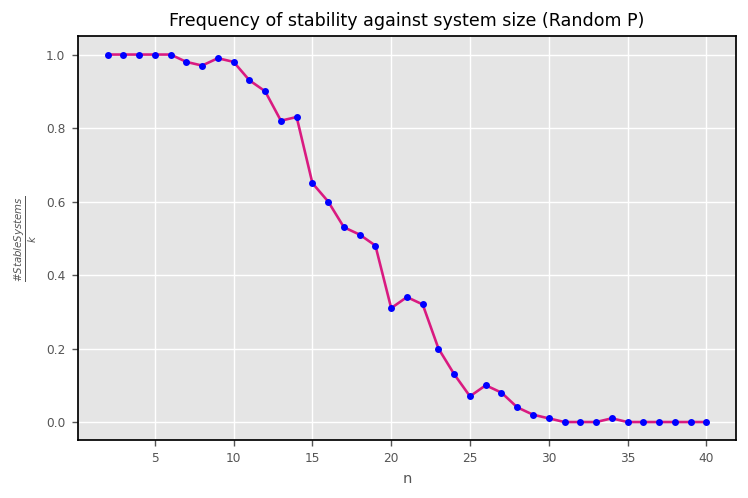

In [32]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)

# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size (Random P)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();
# Fit with Negative binomial ?

The above data have a form similar to
$$ f(x) = a\frac{e^{r(x-d)}}{c+e^{r(x-d)}}, $$
with reals $r<0,$ and $a,c,d>0$.

### Fitting the peculiar curve

In [33]:
from scipy.optimize import curve_fit

In [34]:
def logistic(x, a, r, c, d): # Model Guess 1: Logistic Decay
    y = a * (np.e**(r*(x-d)) / (c + np.e**(r*(x-d))))
    return y

# Model Guess 2: Negative Binomial (Failure Probability)

In [35]:
guess = [1, -0.1, 0.9, 20] # guess from playing with desmos sliders
parameters, covariance = curve_fit(logistic, xdata, ydata, p0 = guess) # least-squares default?
fit_a = parameters[0]
fit_r = parameters[1]
fit_c = parameters[2]
fit_d = parameters[3]
print(fit_a)
print(fit_r)
print(fit_c)
print(fit_d)

1.0306520020488892
-0.2910446314207508
0.7988405239532274
17.08813772221264


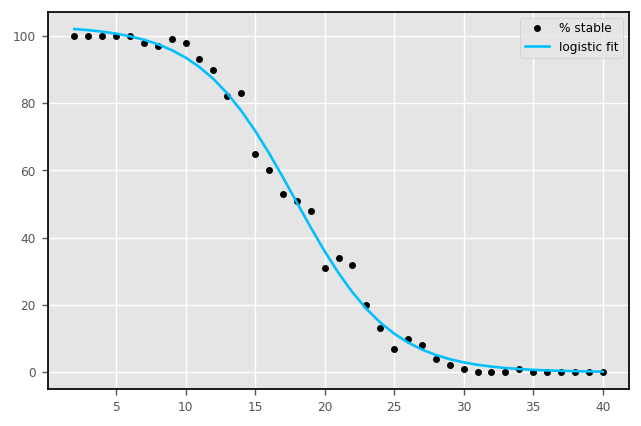

In [36]:
fit_logistic_y = logistic(xdata, fit_a, fit_r, fit_c, fit_d)
plt.plot(xdata, 100*ydata, 'k.', label='% stable');
plt.plot(xdata, 100*fit_logistic_y, 'deepskyblue', label='logistic fit');
plt.legend();

## Back to plotting eigvals

In [37]:
np.any(aEVs > 0)

True

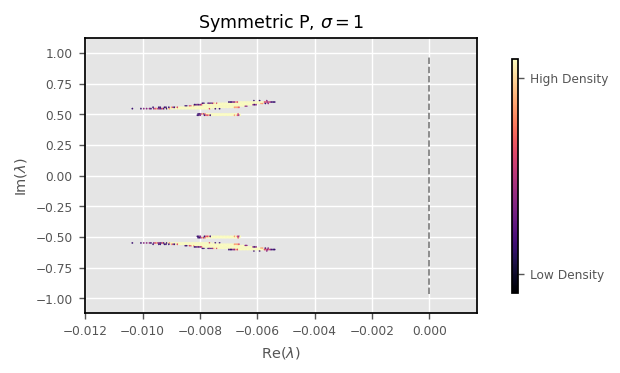

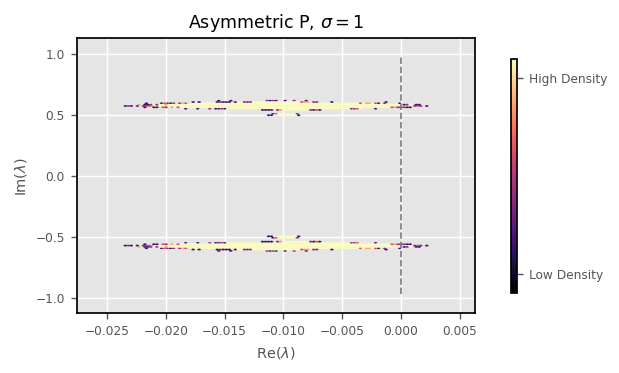

In [38]:
### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(eigval)>0 to k.

#sigs = [0.5,1,2,5,10]
sigs = [1]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 1000     # number of systems to generate

sP = symPvec(sig=1, n=n, k=k)
aP = asymPvec(sig=1, n=n, k=k)

mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)

stability_freqs = [] # len(sigs)

for j, s in enumerate(sigs): # Plotting was being buggy, no longer looping over multiple sigmas
    sEVs = eigval_gen(sP, eps, mu, rho)
    aEVs = eigval_gen(aP, eps, mu, rho)
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value

        x = q.real
        y = q.imag
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (5,3))

        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white', alpha=0) 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 7}
        plt.rc('font', **font)

        # plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')
        plt.ylabel(r'Im($\lambda$)')

        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))

        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))

        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
        cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
        locs = cb.get_ticks()
        tl = locs[-1] * 2 / 25
        cb.set_ticks([tl, locs[-1] - tl])
        cb.set_ticklabels(['Low Density', 'High Density'])

        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))
        
        plt.tight_layout()

plt.show();

# Arnoldi Measures

## Misc.

In [39]:
def community_matr_gen(C_,P_,eps_,mu_,rho_):
    '''
    Returns L, the community matrix (Jacobian) of an O'Dwyer system described by given:
        Consumption matrix C,
        Production matrix P, 
        Exogenous mu,
        rho
    '''
    n = P_.shape[-1]
    k = P_.shape[0]
    I = np.identity(n)
        
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C_, P_, eps_, mu_)
    S_star = S_star_gen(C_, P_, R_star, rho_)
    
    # Community Matrix Partitions
    CS = np.dot(C_, S_star).T.reshape(k,n,1) # can use regular .T because first dimension is 1
    CR = np.dot(C_, R_star).T.reshape(k,n,1)
    
    LA  = -CS * I
    LB = P_ - CR * I
    LC = eps_ * CS * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

In [40]:
def dom_eigvals(A): # for A shape (k,2*n,2*n) ; returns entire eigval (complex, with sign)
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])    
    k = A.shape[0]
    
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[np.arange(0,k), dom_ev_ind]
    
    return dom_ev

In [41]:
def dom_eigval_single(A): # Just for spectral_norm()
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[dom_ev_ind]
    
    return dom_ev

## "Resilience, reactivity and variability..." (2016)

In [42]:
np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
# C = abs(np.random.randn(n,n)) # literally never stable, equilibria are ruined
P = symPvec(sig = 1, n = n, k = k)
# P = asymPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

In [43]:
# Equilibria
R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

# R_star[0,:,:]
# S_star[0,:,:]

### Pre-Arnoldi sanity check

### The 4 measures

In [44]:
# 'A' will mean a (k,2*n,2*n) stack of community matrices (Jacobian evaluated at R_star,S_star)
# Suffix _mb to denote measures computed from O'Dwyer MicroBiome model

#### Asymptotic Resilience

In [45]:
def asym_res(A):
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])
    k = A.shape[0]
    dom_ev = dom_eigvals(A)
    
    R_inf = -dom_ev.real
    
    return R_inf

In [46]:
R_inf_mb = asym_res(J)

#### Deterministic Invariability
$$\mathcal{I}_D = \frac{1}{\sup_{\omega}||(i\omega - A)^{-1}||}$$

In [47]:
# i*omega - A is shorthand for I_n * i*omega - A

In [48]:
from scipy.optimize import minimize
from scipy.optimize import brent
from scipy.optimize import minimize_scalar # which Brent?

In [49]:
def spectral_norm(A): # only takes 1 matrix
    dom_ev = dom_eigval_single(np.dot((A.T).conjugate(), A))

    return np.emath.sqrt((dom_ev.real)) # np.emath.sqrt returns complex if takes negative # Take the real part?

In [50]:
# Find omega that maximizes ||inverse(i*om-A)||_{spectral}
# Objective function:
def determ_invar_OBJ(om, A):
    B = np.linalg.inv(np.eye(A.shape[-1])*complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize    
    return -spectral_norm(B) # negative because we are maximizing

In [51]:
# Deterministic Invariability
def determ_invar(om, A): # assumes you have found argmin omega    
    B = np.linalg.inv(np.eye(A.shape[-1])*complex(0,om) - A)
    
    return 1 / spectral_norm(B)

In [52]:
# Loop through each Community matrix to get their I_D
I_D_mb = []
oms = []
I_D_mb_alt = [] # using scipy.optimize.brent() instead of minimize_scalar()
oms_alt = []
for i in range(k):
    
    out = minimize_scalar(determ_invar_OBJ, args=(J[i,:,:]), method='brent')
    out_alt = minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J[i,:,:]), method='brent')

    oms.append(out.x)
    I_D_mb.append(-1/out.fun) # out.fun is still negative bc of obj function minimizing the opposite to find maximum
    oms_alt.append(out_alt.x)
    I_D_mb_alt.append(-1/out_alt.fun)

I_D_mb = np.array(I_D_mb)
I_D_mb_alt = np.array(I_D_mb_alt)

#### Stochastic Invariability

$$\mathcal{I}_S = \frac{1}{2} ||-\hat{A}^{-1}||^{-1}$$
$$ \hat{A} = A \otimes I + I \otimes A $$

In [53]:
def stoch_invar(A):
    # NOT vectorized bc Kronecker product (at the moment)
    I = np.identity(A.shape[-1])
    A_hat = np.kron(A,I) + np.kron(I,A)
    
    temp = -np.linalg.inv(A_hat)
    spec_norm = spectral_norm(temp)
    
    SI = 0.5 / spec_norm
    
    return SI

In [54]:
I_S_mb = []
for i in range(k):
    I_S_mb.append(stoch_invar(J[i,:,:]))

len(I_S_mb)

I_S_mb = np.array(I_S_mb)

1000

#### Initial Resilience

In [55]:
def init_res(A):
    
    if A.ndim == 2:  # to account for when passing a single community matrix A, shape (2*n,2*n)
        A = A.reshape(1,A.shape[0],A.shape[1])
    k = A.shape[0]
    
    temp = A + np.transpose(A, (0,2,1)) # symmetric matrices have real eigvals
    
    dom_evs = dom_eigvals(temp)
    
    R0 = -0.5* dom_evs
    
    return R0

In [56]:
R_0_mb = init_res(J)
R_0_mb.shape

(1000,)

In [57]:
# These systems have nearly guaranteed stability for small n (less than 6 or so)

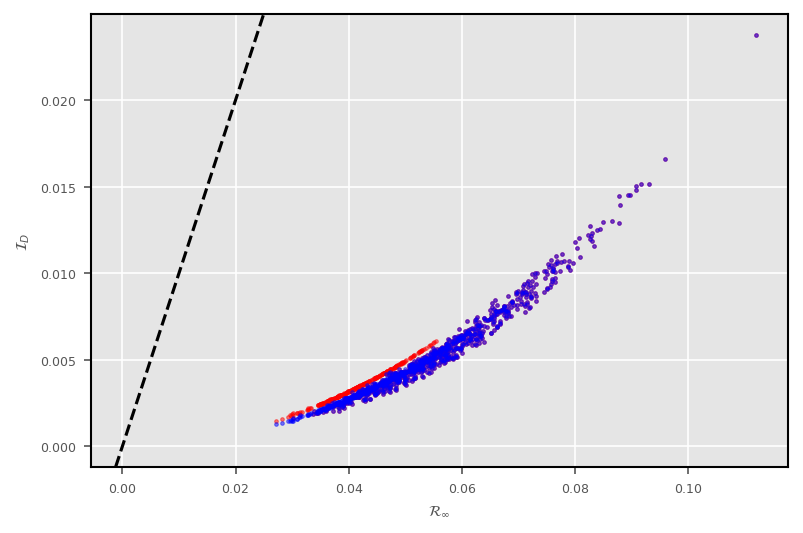

In [58]:
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams.update({'font.size': 6})
plt.scatter(x=R_inf_mb,y=I_D_mb, s=3, c='r', alpha = 0.5);
plt.scatter(x=R_inf_mb,y=I_D_mb_alt, s=3, c='b', alpha = 0.5); # Different optimization parameters, makes I_D smaller as desired
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

### Arnoldi plots of O'Dwyer Systems

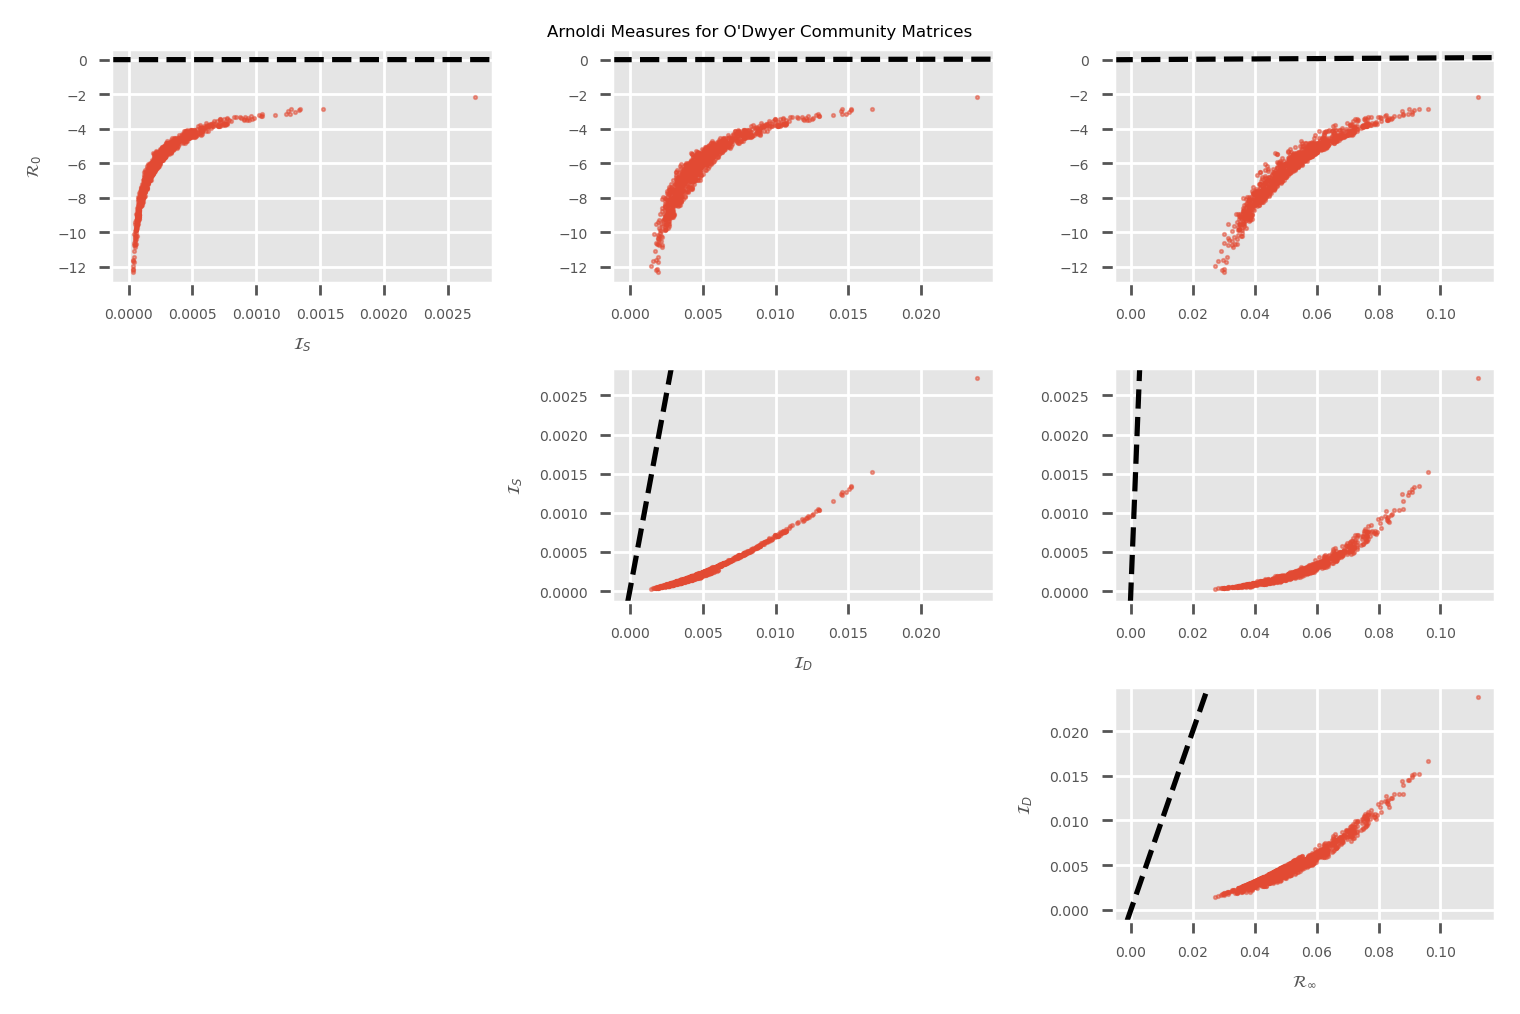

In [59]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})


plt.subplot(3,3,1)
plt.scatter(x=I_S_mb,y=R_0_mb, s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=I_D_mb,y=R_0_mb, s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=R_inf_mb,y=R_0_mb, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=I_D_mb,y=I_S_mb, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=R_inf_mb,y=I_S_mb, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=R_inf_mb,y=I_D_mb, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measures for O\'Dwyer Community Matrices');

plt.tight_layout();

## Copying Arnoldi Plots 

In [60]:
### Copy Arnoldi for sanity check

# np.random.seed(1)
np.random.seed(667)
S = 3
k = 1000
A = np.random.randn(k,S,S)
d = np.random.uniform(-1,0, (k,S))
d_ind = np.diag_indices(S)
A[:, d_ind[0],d_ind[1]] = d
A[0:2,:,:]

array([[[-0.0339146, -0.0628305, -2.2412373],
        [ 0.4838451, -0.4941459,  0.9215031],
        [ 0.2790376, -2.1191639, -0.0529728]],

       [[-0.2506633,  0.4582808,  0.7569159],
        [ 0.5215322, -0.8091574,  0.3345563],
        [ 0.6402031,  1.4538909, -0.7602865]]])

In [61]:
# Get only the stable systems
A_evs = eigvals(A)
A_reals = A_evs.real
neg_real_cts = np.sum(A_reals<0,-1)
stable_inds = np.where(neg_real_cts == S)[0] # S = 3 here, matrix dimension
stable_inds.shape # Scatterplots with have this many points
unstable_inds = np.where(neg_real_cts != S)[0]

(385,)

In [62]:
tempR0 = init_res(A[stable_inds,:,:])

In [63]:
tempRinf = asym_res(A[stable_inds,:,:])

In [64]:
tempI_S = []
for i in stable_inds:
    tempI_S.append(stoch_invar(A[i,:,:]))

tempI_S = np.array(tempI_S)

In [65]:
tempI_D = [] # for brent without bracket
temp_oms = []
tempI_D2 = [] # for brent optimization with bracket; overall better, it seems
temp_oms2 = []
for i in stable_inds:
    out = minimize_scalar(determ_invar_OBJ, args=(A[i,:,:]), method='brent')
    out2 = minimize_scalar(determ_invar_OBJ, bracket=(0,2.25), args=(A[i,:,:]), method='brent', options={'maxiter':1000})
    temp_oms.append(out.x)
    tempI_D.append(-1/out.fun)
    tempI_D2.append(-1/out2.fun)
    temp_oms2.append(out2.x)

tempI_D = np.array(tempI_D)
tempI_D2 = np.array(tempI_D2)
temp_oms = np.array(temp_oms)
temp_oms2 = np.array(temp_oms2)

In [66]:
problem_inds = np.where(tempI_D2>tempRinf)[0] # where does tempI_D break the rules
problem_inds

array([322], dtype=int64)

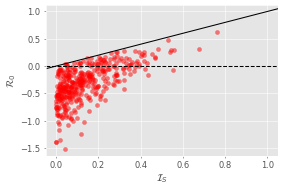

In [165]:
# plt.figure(figsize=(3,3), dpi=100)
mpl.rcParams.update({'font.size': 12})

plt.scatter(tempI_S, tempR0, color='r', alpha=0.5);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),xy2=(1,1), color='k');
plt.axhline(y=0,color='k',linestyle='--');
# plt.scatter(tempI_S[140], tempR0[140], color='b', alpha=1);

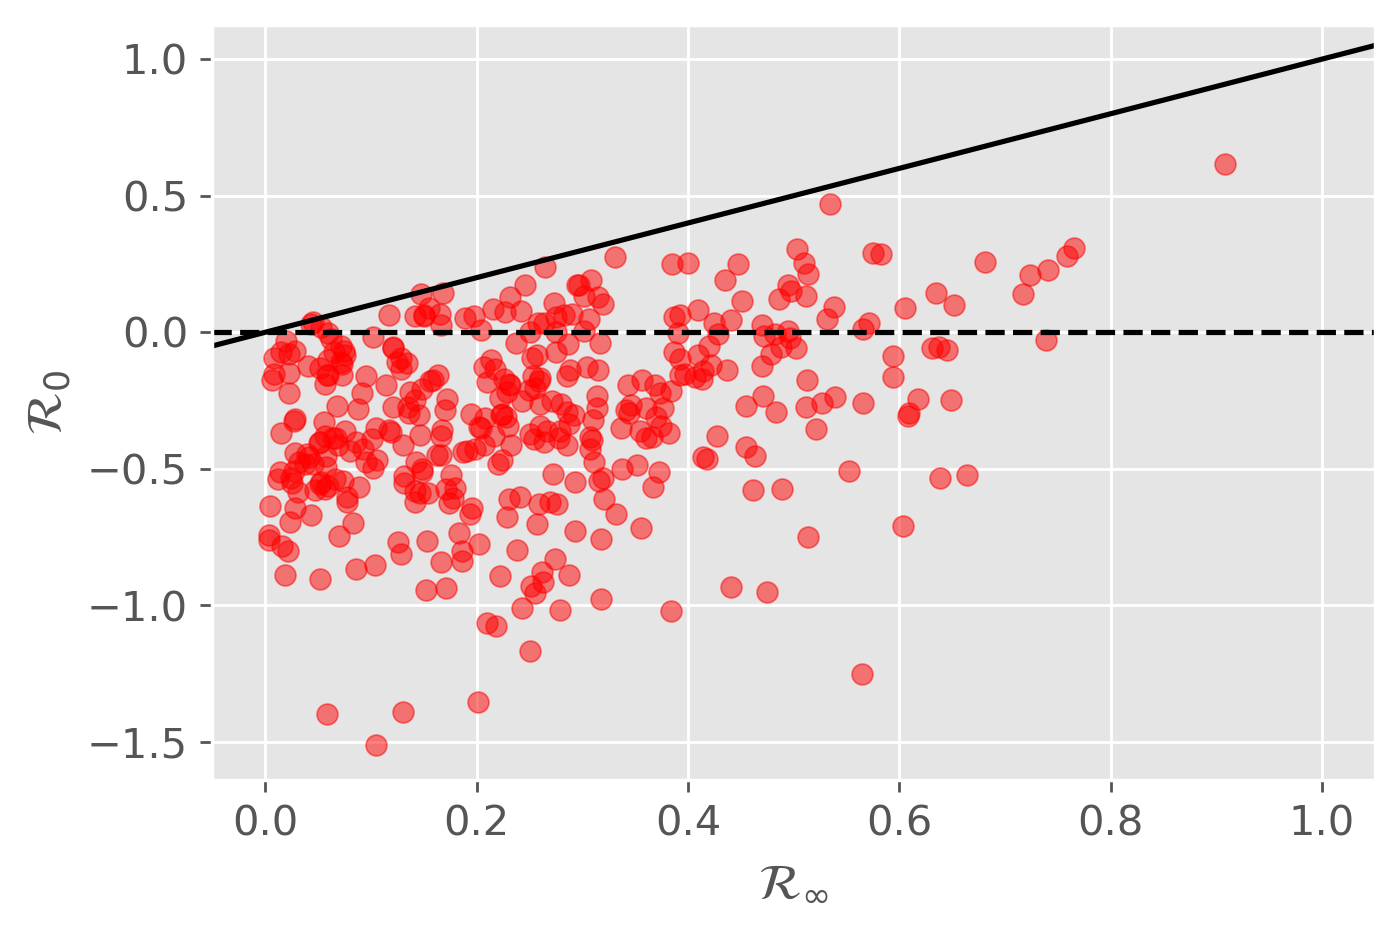

In [68]:
# plt.figure(figsize=(3,3), dpi=100)
plt.scatter(x=tempRinf, y=tempR0, color='red', alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{R}_{0}$');

plt.axline(xy1=(0,0), xy2=(1,1), color = 'k');
plt.axhline(y=0,color='k',linestyle='--');
plt.show();

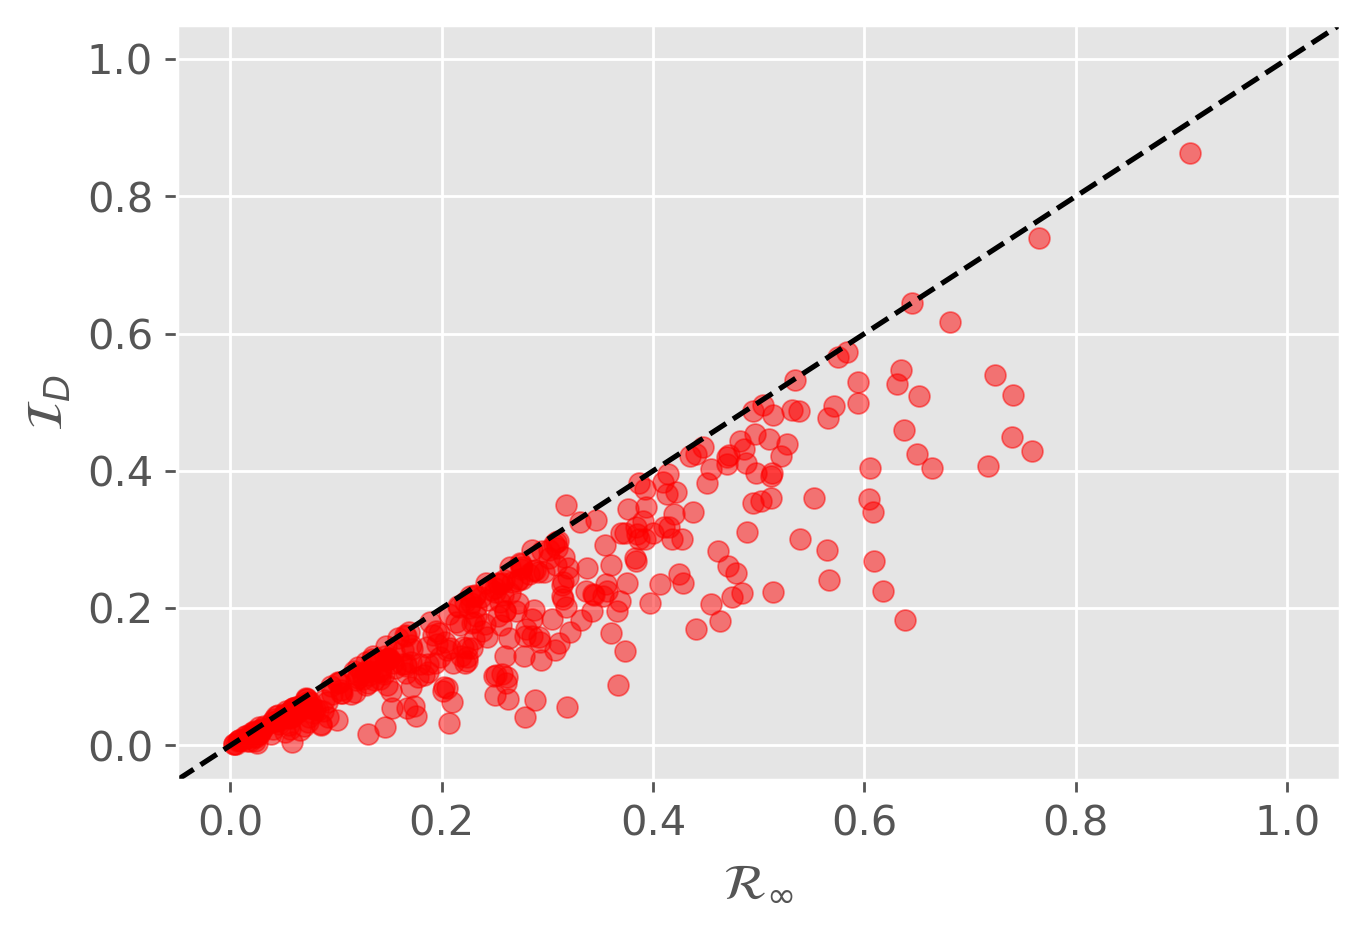

In [69]:
# plt.figure(figsize=(3,3),dpi=100)
# plt.scatter(x=tempRinf[problem_inds], y=tempI_D[problem_inds], color='k', alpha=1);
# plt.scatter(x=tempRinf, y=tempI_D, color='r', alpha=0.5);
plt.scatter(x=tempRinf, y=tempI_D2, color='r', alpha=0.5);

plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
plt.show();

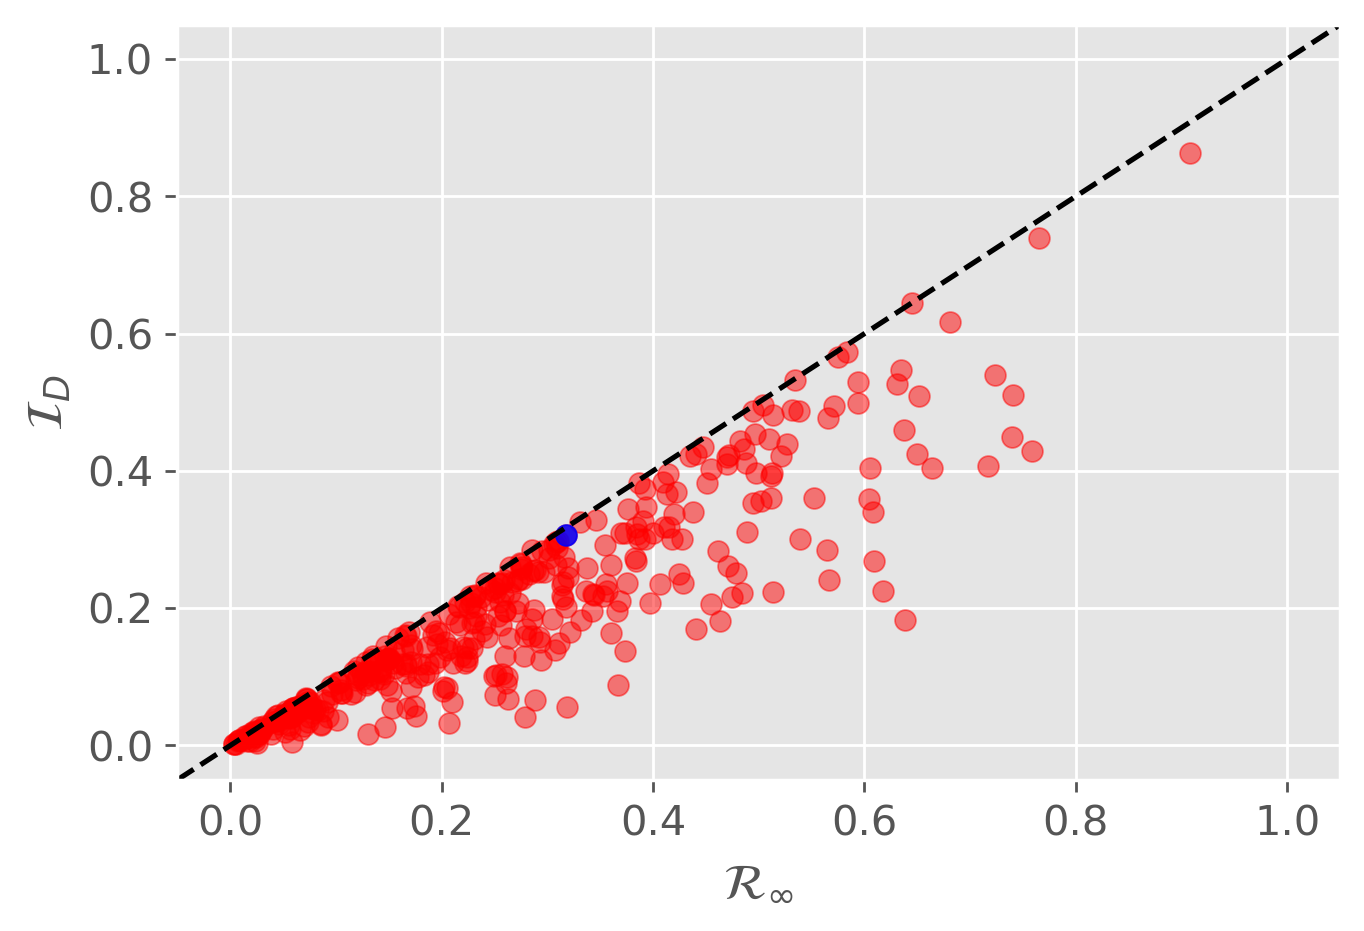

In [70]:
# For any problematic points in Deterministic Invariability, re-optimize but with a method that takes an initial guess
tempI_D_fixed = tempI_D2.copy()

guess = 2
for i in problem_inds:
    tempI_D_fixed[i] = minimize(determ_invar, x0=guess, args=(A[stable_inds[i]]), method='Nelder-Mead').fun

tempI_D2[problem_inds[0]]
tempI_D_fixed[problem_inds[0]]

# plt.figure(figsize=(3,3),dpi=100)
plt.scatter(x=tempRinf, y=tempI_D_fixed, color='r', alpha=0.5);
plt.scatter(x=tempRinf[problem_inds], y=tempI_D_fixed[problem_inds], color='b', alpha=0.85);
# Corrected points in blue
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
plt.show();

## Distribution of community matrix entries

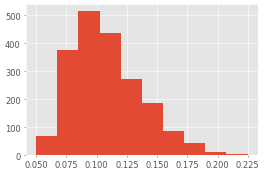

In [71]:
mpl.rcParams['figure.dpi'] = 50
plt.hist(S_star.reshape(-1));

In [72]:
R_star[0,:,:]

array([[18.6339036],
       [14.9003295]])

In [73]:
S_star[0,:,:]

array([[0.0684994],
       [0.0800142]])

## "How ecosystems recover ..." (2018) [CAN SKIP]

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [74]:
### Arnoldi  "How ecosystems recover..."
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [75]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [76]:
# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [77]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [78]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [79]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [80]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

array([[[24.3266659],
        [17.468694 ],
        [22.9295135],
        [23.362705 ],
        [16.8400903]],

       [[14.1387977],
        [20.7062667],
        [10.0114319],
        [18.3690576],
        [24.7727644]]])

array([[[0.049696 ],
        [0.0683519],
        [0.0570859],
        [0.0554536],
        [0.0743812]],

       [[0.0815879],
        [0.0663618],
        [0.114137 ],
        [0.0692367],
        [0.0491362]]])

In [81]:
S_star_gen?

Signature: S_star_gen(C_, P_, R_star_, rho_)
Docstring: <no docstring>
File:      e:\progrumping\microbiome_stability_diversity\<ipython-input-24-98eacb33af99>
Type:      function


In [82]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [83]:
R_arn

array([[[24.3266659],
        [17.468694 ],
        [22.9295135],
        [23.362705 ],
        [16.8400903]],

       [[14.1387977],
        [20.7062667],
        [10.0114319],
        [18.3690576],
        [24.7727644]]])

In [84]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [85]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [86]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [87]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

0.6065818374784634

0.2212595687776231

In [88]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [89]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [90]:
R_star_gen?

Signature: R_star_gen(C_, P_, eps_, mu_)
Docstring:
Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).

No argument for number of sub-R_stars because that is inferred from 0th dimension of 'P_' argument.
File:      e:\progrumping\microbiome_stability_diversity\<ipython-input-21-9be506219117>
Type:      function


In [91]:
RS_arn

array([[[ 7.9836072],
        [13.8027271],
        [ 0.1558248],
        [ 0.0802624]]])

In [92]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

1.0

In [93]:
u_ex

array([ 0.588944 , -0.8081334,  0.0079866, -0.0012431])

In [94]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [95]:
aP_arn
RS_arn

array([[0.593442 , 1.8884423],
       [0.4024598, 0.5622395]])

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

In [96]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [97]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [98]:
step
len(step)

[-2.7755575615628914e-17, 1.0408340855860843e-16, 0.0, -1.3877787807814457e-17]

4

In [99]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [100]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

0.9999999999999999

array([-0.5833282,  0.8122208,  0.0010606,  0.004954 ])

In [101]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

array([-0.5833282,  0.8122208,  0.0010606,  0.004954 ])

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

[7.400279044916338,
 14.614947834221857,
 0.1568853505170469,
 0.08521639127879387]

In [102]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))

In [103]:
sol.shape
sol = np.array(sol)

(1001, 4)

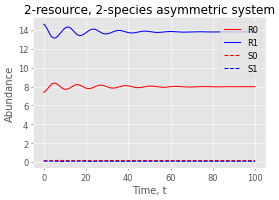

In [104]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

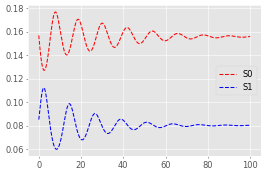

In [105]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


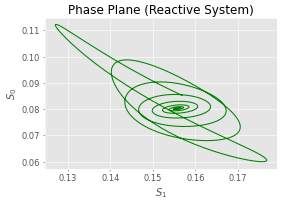

In [106]:
plt.plot(sol[:,2], sol[:,3], 'g');
plt.title('Phase Plane (Reactive System)');
plt.xlabel(r'$S_1$');
plt.ylabel(r'$S_0$');

In [107]:
### NEXT STEPS FOR ARNOLDI TOOLS:
    ### Pick a threshold for the oscillations such that settles in ...

In [108]:
RS_arn
sol

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

array([[ 7.400279 , 14.6149478,  0.1568854,  0.0852164],
       [ 7.4104398, 14.6003087,  0.1546331,  0.086949 ],
       [ 7.4222681, 14.5832852,  0.1524552,  0.0886817],
       ...,
       [ 7.989081 , 13.8049451,  0.1558973,  0.0804053],
       [ 7.9889625, 13.8047394,  0.1559184,  0.0804095],
       [ 7.9888313, 13.8045308,  0.155939 ,  0.0804134]])

In [109]:
RS_arn

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

In [110]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

array([[ 5.8332816e-01, -8.1222077e-01, -1.0605657e-03, -4.9539994e-03],
       [ 5.7316741e-01, -7.9758167e-01,  1.1916376e-03, -6.6865728e-03],
       [ 5.6133909e-01, -7.8055816e-01,  3.3695922e-03, -8.4192628e-03],
       ...,
       [-5.4737470e-03, -2.2180885e-03, -7.2524357e-05, -1.4290253e-04],
       [-5.3552766e-03, -2.0123519e-03, -9.3632408e-05, -1.4715483e-04],
       [-5.2240792e-03, -1.8037653e-03, -1.1425627e-04, -1.5099067e-04]])

In [111]:
# plt.plot(t, sol[:,0], 'r', sol[:,1],'b', sol[:,2],'r--', sol[:,3],'b--');

# Diversity Measures
$$ ^q \lambda = \sum^{S}_{i=1} p_i^q$$
For $q=1$, all species weighted equally, "without favoring either common or rare species."

All diversity indices
of a given order $q$ have the same true diversity $^qD$

In [112]:
### Parameter/System Reminder
    ### SAME as from section "Arnoldi Measures"

np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = symPvec(sig = 1, n = n, k = k)
# P = asymPvec(sig = 1, n = n, k = k) # FOR n>5, no (empirical?) guarantee of stability
J = community_matr_gen(C,P,eps,mu,rho)
J.shape

R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

(1000, 4, 4)

In [113]:
## O'Dwyer Stability measures are already computed by this point
# NOTE: Stability measures computed from O'Dwyer systems are stored as:
# R_0_mb
# I_S_mb
# I_D_mb
# R_inf_mb

# Now, will have _mb## suffix to denote the size of the system (EX: _mb10 for n=10)

## Jost    
All diversity index functions below will take equilibrium vector $N$ and return raw index, not the numbers equivalent.

$H_A$, $H_B$ are any orthogonal quantities/qualities of a diversity index H (EX: alpha and beta diversity, evenness and richness).

In [114]:
def normalize(N):
    '''
    Makes column vector(s) length 1.
    '''
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
    norms = np.sqrt(np.sum(np.square(N),1)).reshape(N.shape[0],1,1)
    N = N/norms
    
    return N

In [115]:
def sum_to_one(N):
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
        
    return N/np.sum(N,1).reshape(N.shape[0],1,1)

In [116]:
s_star = sum_to_one(S_star)
r_star = sum_to_one(R_star)

### Simpson concentration
$$H \equiv \sum^{S}_{i=1} p_i^2$$
$$D = \frac{1}{H}$$
$$ H_A \times H_B = H_{tot}$$

In [117]:
def simpson_conc(N):
    H = np.sum(np.square(N),1)
    # D = 1/H
    
    return H

In [118]:
simpson_s = simpson_conc(s_star)
simpson_r = simpson_conc(r_star)

### Shannon Entropy
$$H \equiv -\sum^{S}_{i=1} p_i \ln(p_i)$$
$$ D = e^{H}$$
H:
$$ H_A + H_B = H_{tot}$$
D (exponential of Shannon entropy):
$$ H_A \times H_B = H_{tot}$$

In [119]:
def shannon_entropy(N): 
    if (np.all(N>0)):
        H = -np.sum(N*np.log(N), 1)
    else:
        H = -999 # Error value, to point out unviable equilibria in gLV.
    # D = np.exp(H).reshape(N.shape[0],1,1)
    return H

In [120]:
shannon_s = shannon_entropy(s_star)

shannon_r = shannon_entropy(r_star)
shannon_sr = np.concatenate((shannon_s,shannon_r))

### Gini-Simpson index
$$H \equiv 1 - \sum^{S}_{i=1} p_i^2$$
$$ D = 1/(1-H) $$
$$ H_A + H_B - (H_A \times H_B) = H_{tot}$$

In [121]:
def gini_simpson_index(N):
    H = 1 - np.sum(np.square(N), axis = 1)
    # D = 1/(1-H)
    
    return H

In [122]:
gini_simp_s = gini_simpson_index(s_star)
gini_simp_r = gini_simpson_index(r_star)
gini_simp_sr = np.concatenate((gini_simp_s,gini_simp_r))

In [123]:
# Get numbers equivalents from Gini-Simpson
D_s = 1/(1-gini_simp_s)
D_r = 1/(1-gini_simp_r)
D_sr = np.concatenate((D_s,D_r))

In [124]:
np.mean(simpson_s)
np.mean(shannon_s)
np.mean(gini_simp_s)
np.mean(D_s)

0.5061642173101898

0.6869369197545867

0.4938357826898102

1.976340939492245

### HCDT entropy
$$ H \equiv \frac{1 - \sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = [(1-(q-1)H)]^{1/(1-q)} $$
$$ H_A + H_B - (q-1)(H_A)(H_B) = H_{tot}$$

In [125]:
def hcdt_entropy(N, q=2):
    p = sum_to_one(N)
    if q==1:
        return shannon_entropy(p) # Degenerates to Shannon entropy
    else:
        return (1 - np.sum(np.power(p,q), 1) / (q-1) )

### Renyi entropy
$$ H \equiv \frac{-\ln\sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = e^H $$
$$ H_A + H_B = H_{tot}$$

In [126]:
def renyi_entropy(N, q=2):
    p = sum_to_one(N)
    if q==1:
        return shannon_entropy(p) 
    else:
        return -np.log(np.sum(np.power(p,q), 1)) / (q-1)

### Universal

$$ ^q D_{tot} = ^q D_A \times ^qD_B$$
$$ D(H_{\gamma}) = D(H_{\alpha})D(H_{\beta}) $$ (Whittaker's law) 

$$^qD_{\alpha} \equiv D(^q\lambda_{\alpha})$$ 
$$ =  \left[ \frac{\sum^C_{j=1}[w^q_j \sum^S_{i=1} (p^q_{ij})]}{\sum^C_{j=1}(w^q_j)} \right]^{1/(1-q)} $$

where S is number of species, C is number of communities, $w_j$ is statistical weight of community $j$, and q is partiality to rare or common species.

Above undefined for q=1. Limit:
$$^1 D_{\alpha} = exp\left[ \sum^C_{j=1}[-w_j \sum^S_{i=1}(p_{ij}\ln p_{ij})] \right]$$

Alpha:
$$ ^qD_{\alpha} = ^q \lambda^{1/(1-q)}_{\alpha}$$
Gamma:
$$ ^qD_{\gamma} = ^q \lambda^{1/(1-q)}_{\gamma}$$

In [127]:
# Universal numbers equivalent
def numbers_equiv_alpha(w,p,q):
    '''
    There are C communities and S species.
    
    Takes community weights w (vector of length C), species probabilities p of size (S,C), and order q of the diversity index.
    Returns numbers equivalent of diversity index's alpha component.
    '''
    w = w.reshape(p.shape[0],1)
    
    if (q==1): # undefined case, need formula that takes the limit as q->1
        D_alpha = np.exp(np.sum(-w * np.sum(p*np.log(p),1) ))

    else:
        num = np.sum(np.power(w,q)*np.sum(np.power(p,q),1) ) # take the species sums of p with axis=0
        den = np.sum(np.power(w,q))
        
        D_alpha = np.power(num/den, 1/(1-q))
        
    return D_alpha

In [128]:
def numbers_equiv_gamma(w,p,q):
    w = w.reshape(p.shape[0],1,1)
    
    weight_sum = np.sum(w*p)
    
    if (q==1):
        D_gamma = np.exp(np.sum(-weight_sum*np.log(weight_sum)))
        
    else:
        # Really, Jost only explicitly gives formula for even weights. Should work like this, right?
        D_gamma = np.power(np.sum(w*p), q)
        D_gamma = np.power(D_gamma, 1/(1-q))
        
    return D_gamma 

In [129]:
k
n = 2

1000

In [130]:
w = np.ones(k)/k # assume k equally weighted communities? Like from k different communities
D1_alpha = numbers_equiv_alpha(w, s_star, 1)

D1_gamma = numbers_equiv_gamma(w, s_star, 1)
print('alpha: ', D1_alpha)
print('gamma: ', D1_gamma)
D1_beta = D1_gamma/D1_alpha
print('beta: ', D1_beta)

alpha:  1.9876179660146078
gamma:  1.0
beta:  0.5031147922279601


In [131]:
numbers_equiv_alpha(w,s_star,1)

1.9876179660146078

In [132]:
numbers_equiv_alpha(w,s_star,2)

1.975643409394102

In [133]:
numbers_equiv_alpha(w,s_star,-1)

2.012867374755755

#  Stability vs. Diversity

## 2-Species system

In [134]:
# # O'Dwyer n=2 Plots
# plt.figure(figsize=(7,6),dpi=250)
# mpl.rcParams.update({'font.size': 4})
# plt.suptitle('Stability Measures vs. Diversity Indices ($n=2$)');

# ### Initial Resilience (Row 1) ###
# plt.subplot(4,4,1);
# plt.scatter(simpson_s, R_0_mb, s = 1, alpha=0.5, color = 'orange');
# plt.ylabel(r'$\mathcal{R}_{0}$');

# plt.subplot(4,4,2);
# plt.scatter(shannon_s, R_0_mb, s = 1, alpha=0.5, c = 'orange');

# plt.subplot(4,4,3);
# plt.scatter(gini_simp_s, R_0_mb, s = 1, alpha=0.5, c = 'orange');

# plt.subplot(4,4,4);
# plt.scatter(D_s, R_0_mb, s = 1, alpha=0.5, color = 'orange');

# ### Asymptotic Resilience (Row 2) ###
# plt.subplot(4,4,5);
# plt.scatter(simpson_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');
# plt.ylabel(r'$\mathcal{R}_{\infty}$');

# plt.subplot(4,4,6);
# plt.scatter(shannon_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

# plt.subplot(4,4,7);
# plt.scatter(gini_simp_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

# plt.subplot(4,4,8);
# plt.scatter(D_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

# ### Stochastic Invariability (Row 3) ###
# plt.subplot(4,4,9);
# plt.scatter(simpson_s, I_S_mb, s = 1, alpha=0.5, color = 'red');
# plt.ylabel(r'$\mathcal{I}_S$');

# plt.subplot(4,4,10);
# plt.scatter(shannon_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

# plt.subplot(4,4,11);
# plt.scatter(gini_simp_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

# plt.subplot(4,4,12);
# plt.scatter(D_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

# ### Deterministic Invariability (Row 4) ###
# plt.subplot(4,4,13);
# plt.scatter(simpson_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
# plt.ylabel(r'$\mathcal{I}_D$');
# plt.xlabel('Simpson Concentration(S)');

# plt.subplot(4,4,14);
# plt.scatter(shannon_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
# plt.xlabel('Shannon Entropy(S)');

# plt.subplot(4,4,15);
# plt.scatter(gini_simp_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
# plt.xlabel('Gini-Simpson(S)');

# plt.subplot(4,4,16);
# plt.scatter(D_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
# plt.xlabel('Numbers Equivalent(S)');

# plt.tight_layout();

In [135]:
# Numbers equivalents column shows tendency toward (a mode of) ~2.0 effective species, 
    # a result of many species vectors being split about 50/50 at equilbrium.
# We know that the Numbers Equivalents never dip below 1 for an n=2 system.

In [136]:
s_star[np.argmin(D_s)] # The equilbrium responsible for the left-most point on most of the above plots.

array([[0.6945448],
       [0.3054552]])

## n-Species system

In [137]:
# Add lo(w)ess to plots
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [138]:
class ODsystem:
    '''
    Class to make O'Dwyer systems + their community matrices and equilibria + Arnoldi Measures.
    VERY slow when n>~6, a problem from being a class and for-looping I_S and I_D
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species and number of resources
    mu, vector of mortality rates
    rho, vector of resource influx rates
    eps, resource consumers' conversion efficiency of biomass
    sig_P, standard deviation of entries in production matrix P
    C, consumption matrix
    '''
    def __init__(self, k_=1000,n_=5, mu_=None, rho_=None, eps_=0.25, sig_P_=1, C_ = None, is_sym=True):
        self.k = k_
        self.n = n_
        self.eps = eps_
        self.sig_P = sig_P_
        
        if mu_ is None:
            self.mu = np.ones(self.n).reshape(self.n,1)
        else:
            self.mu = mu_
            
        if rho_ is None:
            self.rho = np.ones(self.n).reshape(self.n,1)
        else:
            self.rho = rho_
            
        if C_ is None:
            self.C = np.identity(self.n)
        else:
            self.C = C_
        
        if is_sym:
            self.P = symPvec(sig = self.sig_P, n = self.n, k = self.k)
        else:
            self.P = asymPvec(sig = self.sig_P, n = self.n, k = self.k)
        
        self.J = community_matr_gen(self.C,self.P,self.eps,self.mu,self.rho)

        self.R_star = R_star_gen(self.C,self.P,self.eps,self.mu)
        self.S_star = S_star_gen(self.C,self.P,self.R_star,self.rho)
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measures ###
        self.s_star = sum_to_one(self.S_star)
        self.r_star = sum_to_one(self.R_star)

        self.simpson_s = simpson_conc(self.s_star)
        self.shannon_s = shannon_entropy(self.s_star)
        self.gini_simp_s = gini_simpson_index(self.s_star)
        self.hcdt_entropy_s = hcdt_entropy(self.s_star, q=2)
        self.renyi_entropy_s = renyi_entropy(self.s_star, q=2)
        self.D_s = 1/(1-self.gini_simp_s)
        
    def stab_div_plot(self, fsize=(7,6), res = 250, fontsize=4, q=2, lowess_frac=None):
        q_renyi=q
        q_hcdt=q
        # q_renyi = int(input('q (order of diversity) for Renyi entropy?'))
        # q_hcdt = int(input('q for HCDT entropy?'))
        hcdt = hcdt_entropy(s_star, q=q_hcdt)
        renyi = renyi_entropy(s_star, q=q_renyi)
                
        xlist = [self.simpson_s, self.shannon_s, self.gini_simp_s, hcdt, renyi, self.D_s]
        xnames = ['Simpson', 'Shannon', 'Gini-Simpson', r'HCDT, q={}'.format(q_hcdt), 'Renyi, q={}'.format(q_renyi), 'Numbers Equivalent']
        ylist = [self.R_0, self.R_inf, self.I_S, self.I_D]
        ynames = [r'$\mathcal{R}_0$', r'$\mathcal{R}_{\infty}$', r'$\mathcal{I}_S$', r'$\mathcal{I}_D$']
        
        plt.figure(figsize=fsize, dpi=res)
        plt.style.use('ggplot')
        mpl.rcParams.update({'font.size': fontsize})
        thetitle = 'Stability Measures vs. Diversity Indices ($n=${})'.format(self.n)
        if lowess_frac:
            thetitle = thetitle + '\nLOWESS with fraction {}'.format(np.round(lowess_frac,3))
        plt.suptitle(thetitle);

        
        colors = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000', '#00000f']
        
        dimx = len(xlist)
        dimy = len(ylist)
        
        for i,stab in enumerate(ylist):
            for j,divind in enumerate(xlist):
                plt.subplot(4,6,i*dimx+j+1)
                plt.scatter(divind, stab, s = 1, alpha=0.5, color = colors[j%dimx]);
                if lowess_frac:
                    w = lowess(stab.reshape(-1), divind.reshape(-1), frac=lowess_frac)
                    if j != 5:
                        plt.plot(w[:,0], w[:,1], c='black', linestyle='dashed', linewidth=0.5, alpha=1.00)
                    else:
                        plt.plot(w[:,0], w[:,1], c='red', linestyle='dashed', linewidth=0.5, alpha=1.00)
                if j%dimx == 0:
                    plt.ylabel(ynames[i]);
                if i == dimy-1:
                    plt.xlabel(xnames[j]);

        
        plt.tight_layout();

In [139]:
# Using ODsystem:
    # Really only need to specify n_, the rest is pretty standard for O'Dwyer systems
    # WARNING: If n_>5, to guarantee stability of all systems, use is_sym=True (symmetric P)

In [140]:
np.random.seed(667)
OD2 = ODsystem(n_=2)

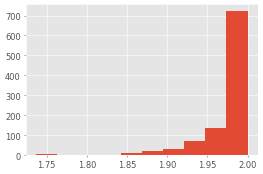

In [141]:
plt.hist(OD2.D_s); # (Distance from) mean effective number of species should be distributed how?

In [142]:
np.random.seed(667)
OD3 = ODsystem(n_=3)

np.random.seed(667)
OD5 = ODsystem(n_=5)

# np.random.seed(667)
# OD10 = ODsystem(n_=10) # VEERYYY slow. We are in quadratic time. It does finish eventually.

# np.random.seed(667)
# OD15 = ODsystem(n_=15)

# np.random.seed(667)
# OD20 = ODsystem(n_=20)

### Load large O'Dwyer systems from local files

In [143]:
import pickle # Save OD10-20 bc they are quite slow to calculate every single time.

In [144]:
# # Run to save objects locally once calculated
# with open(r'E:\Progrumping\Microbiome\OD10.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD10, OD_obj_file)
# with open(r'E:\Progrumping\Microbiome\OD15.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD15, OD_obj_file)
# with open(r'E:\Progrumping\Microbiome\OD20.ODsystem', 'wb') as OD_obj_file: # (w)rite in (b)inary mode
#     pickle.dump(OD20, OD_obj_file)

In [145]:
# Run to load from local.

with open(r'.\OD10.ODsystem', 'rb') as OD_obj_file:
    OD10 = pickle.load(OD_obj_file)
with open(r'.\OD15.ODsystem', 'rb') as OD_obj_file:
    OD15 = pickle.load(OD_obj_file)
with open(r'.\OD20.ODsystem', 'rb') as OD_obj_file:
    OD20 = pickle.load(OD_obj_file)
    
# r'E:\Progrumping\Microbiome\OD20.ODsystem'

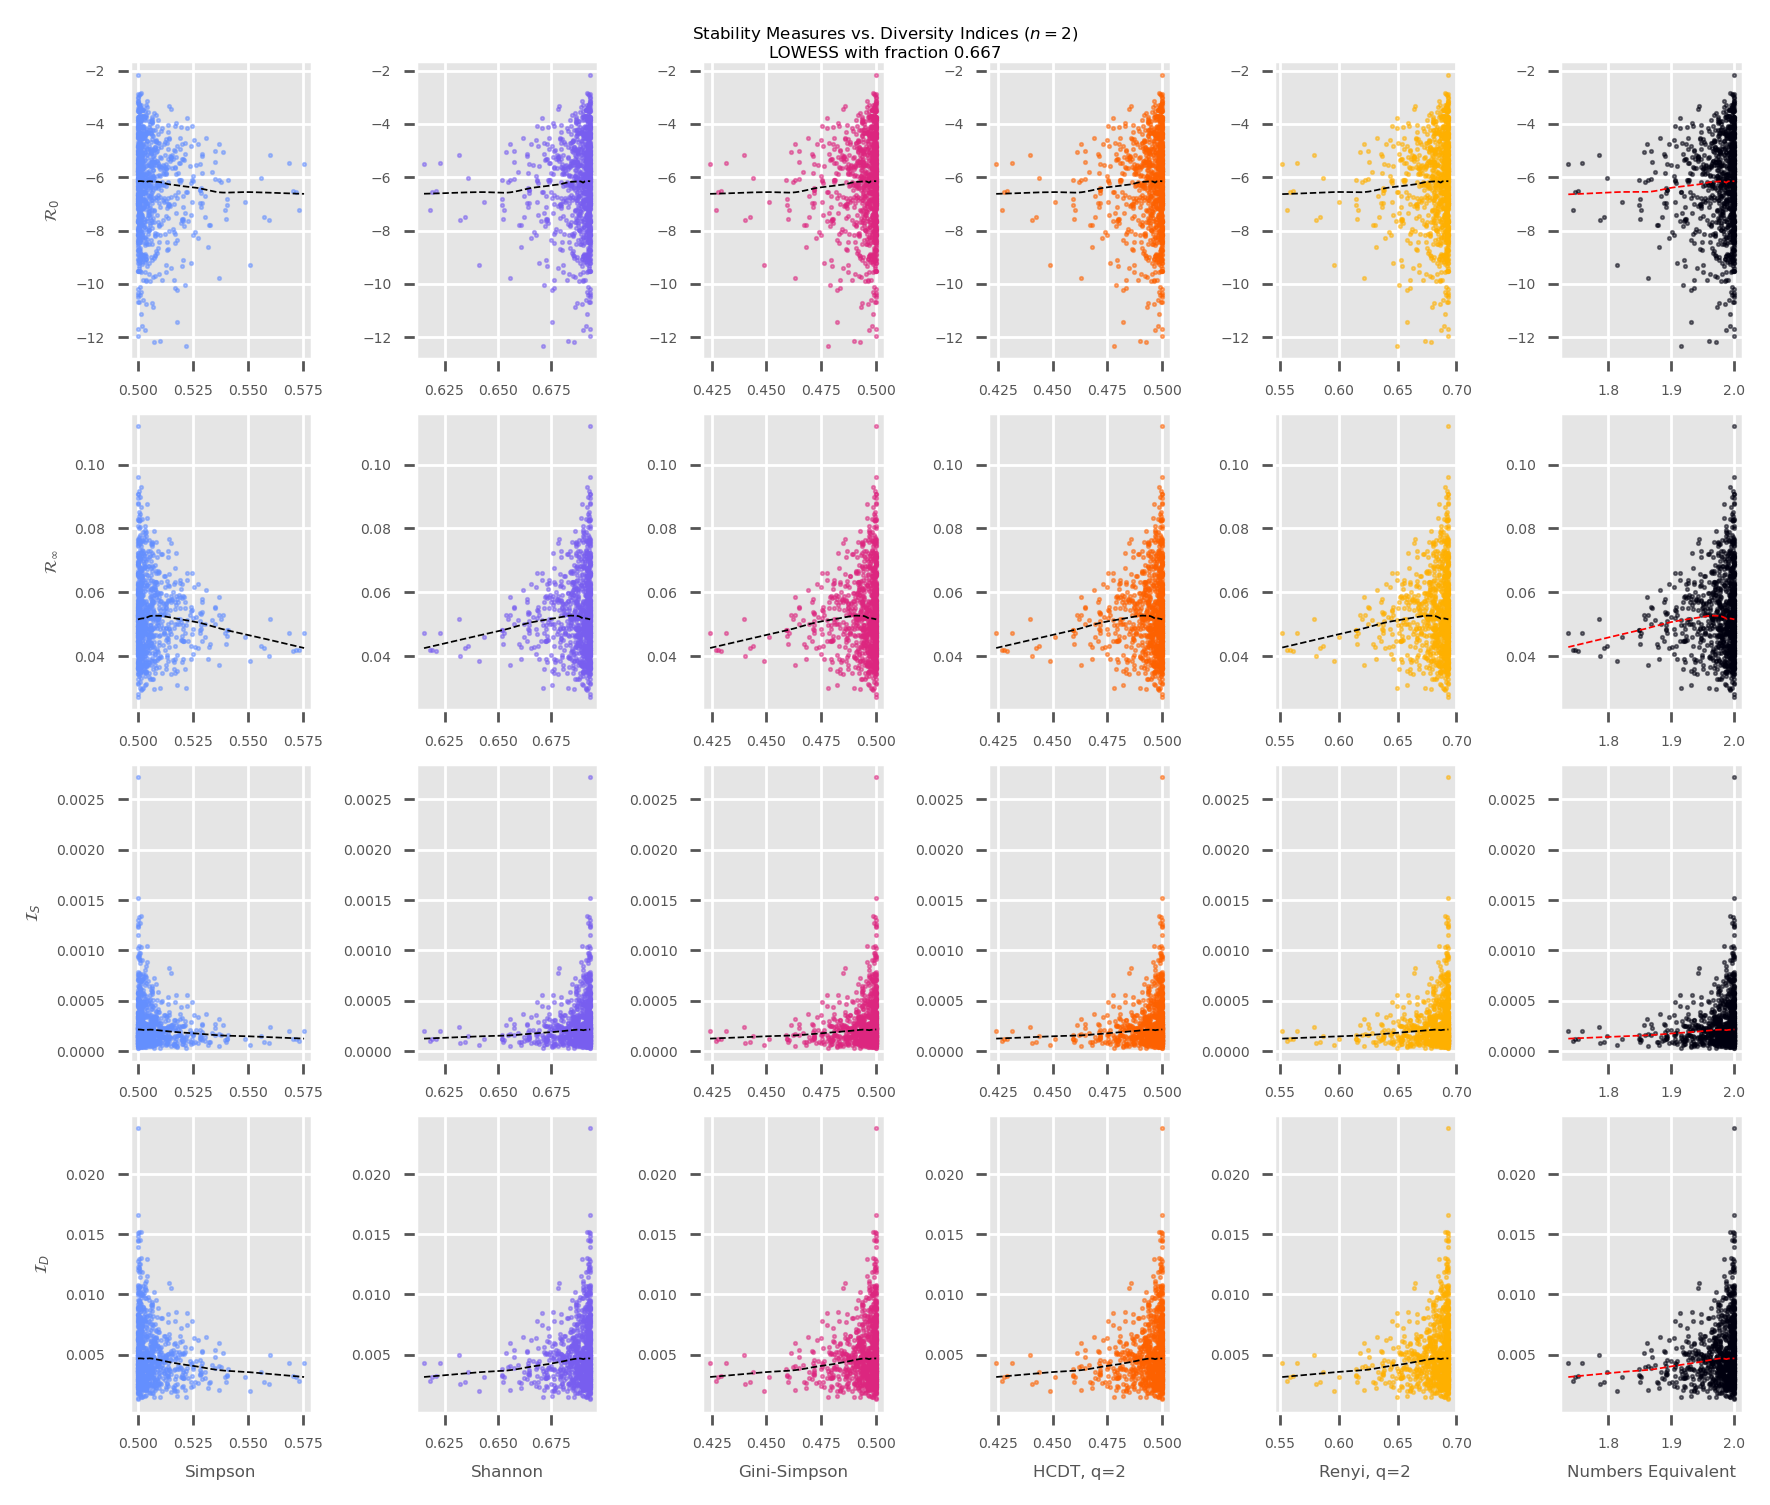

In [146]:
OD2.stab_div_plot(lowess_frac=2./3) # 

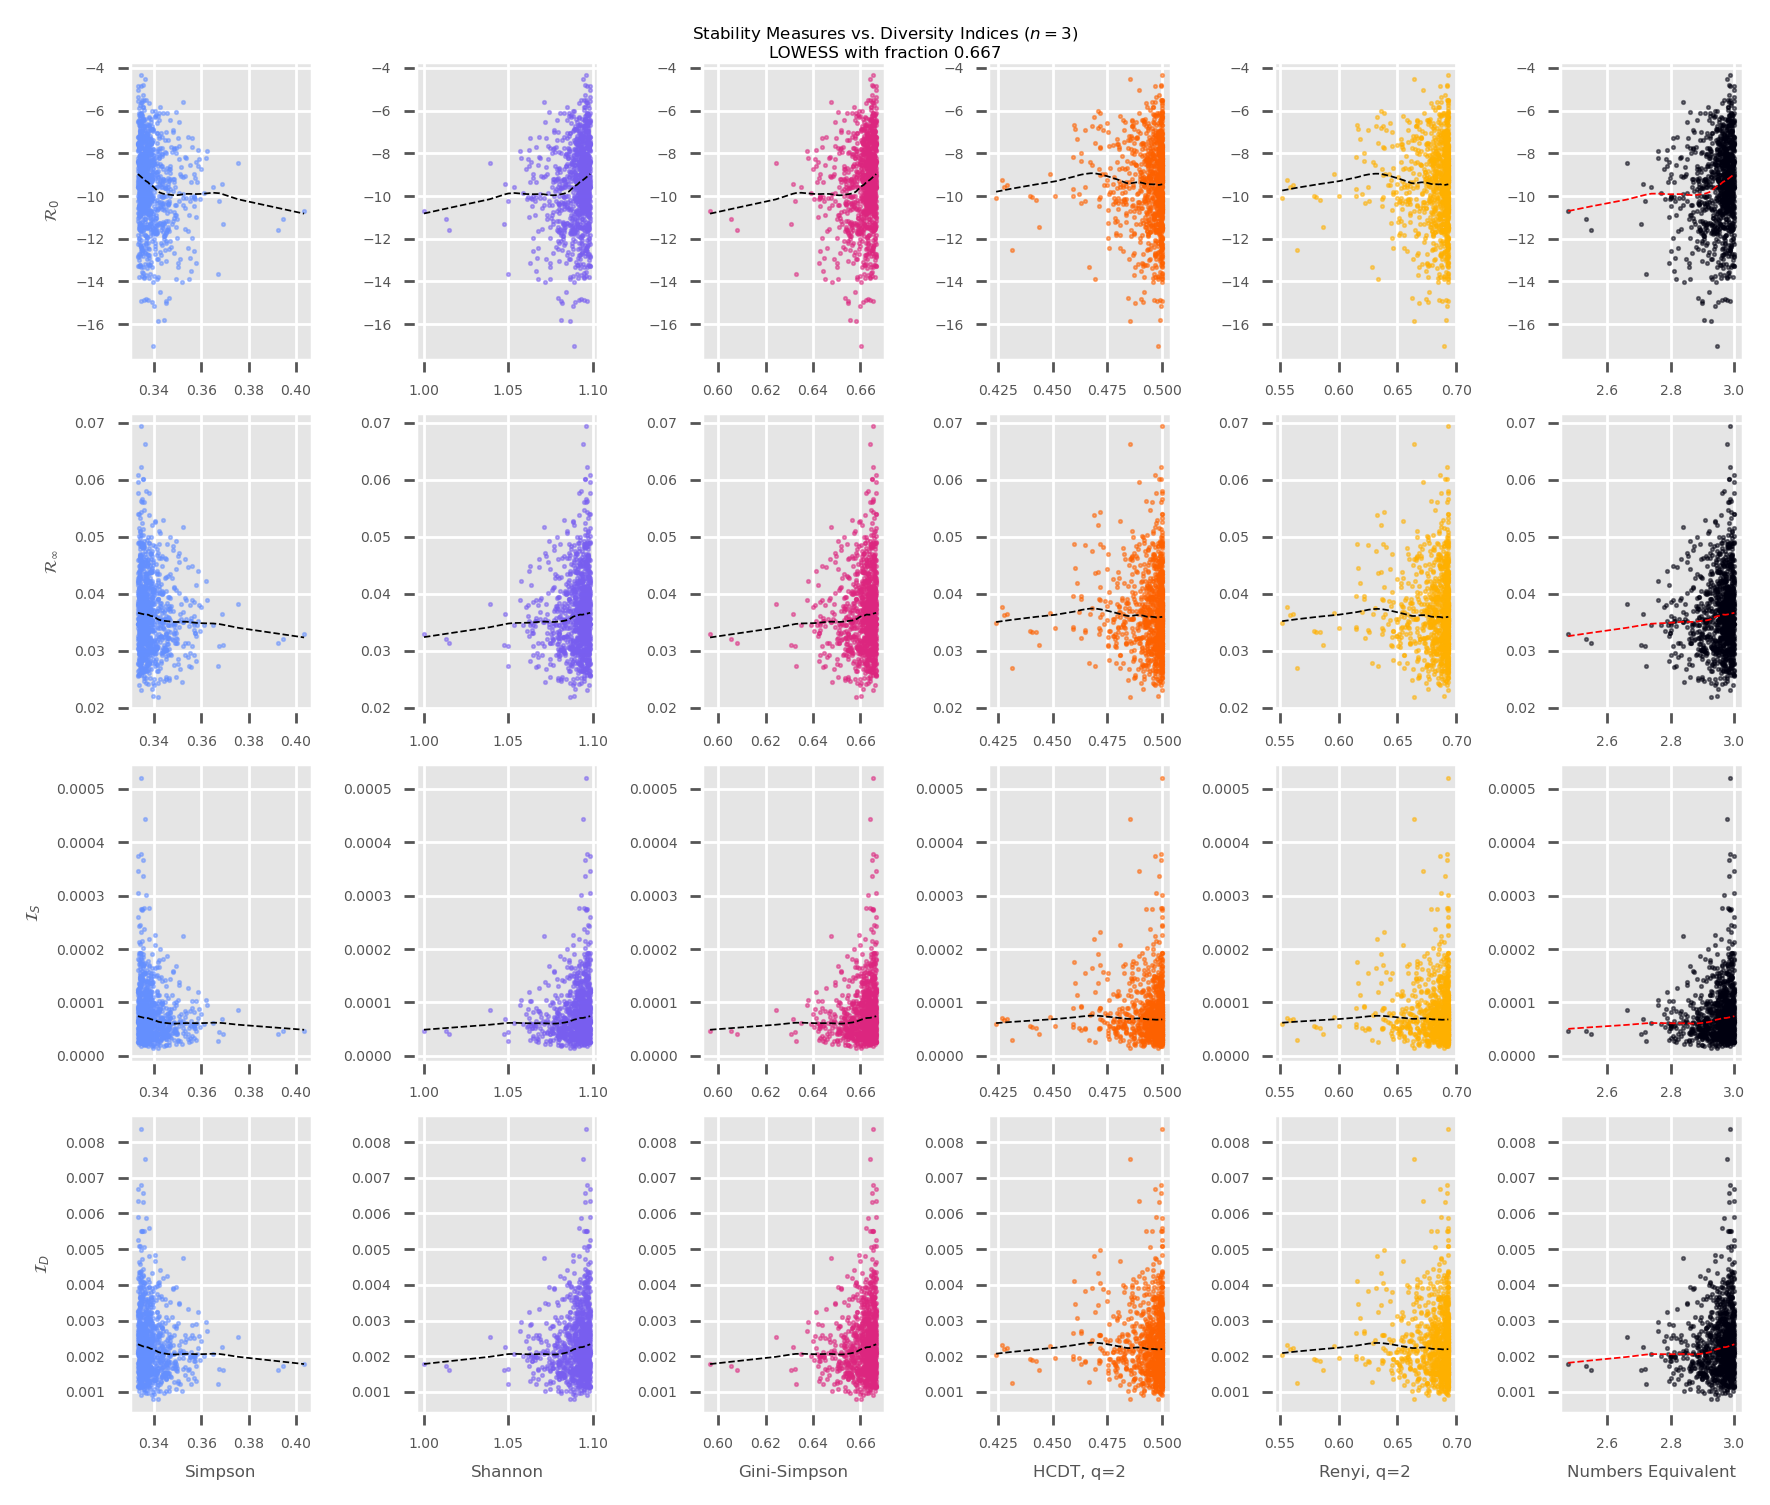

In [147]:
OD3.stab_div_plot(lowess_frac=2./3)

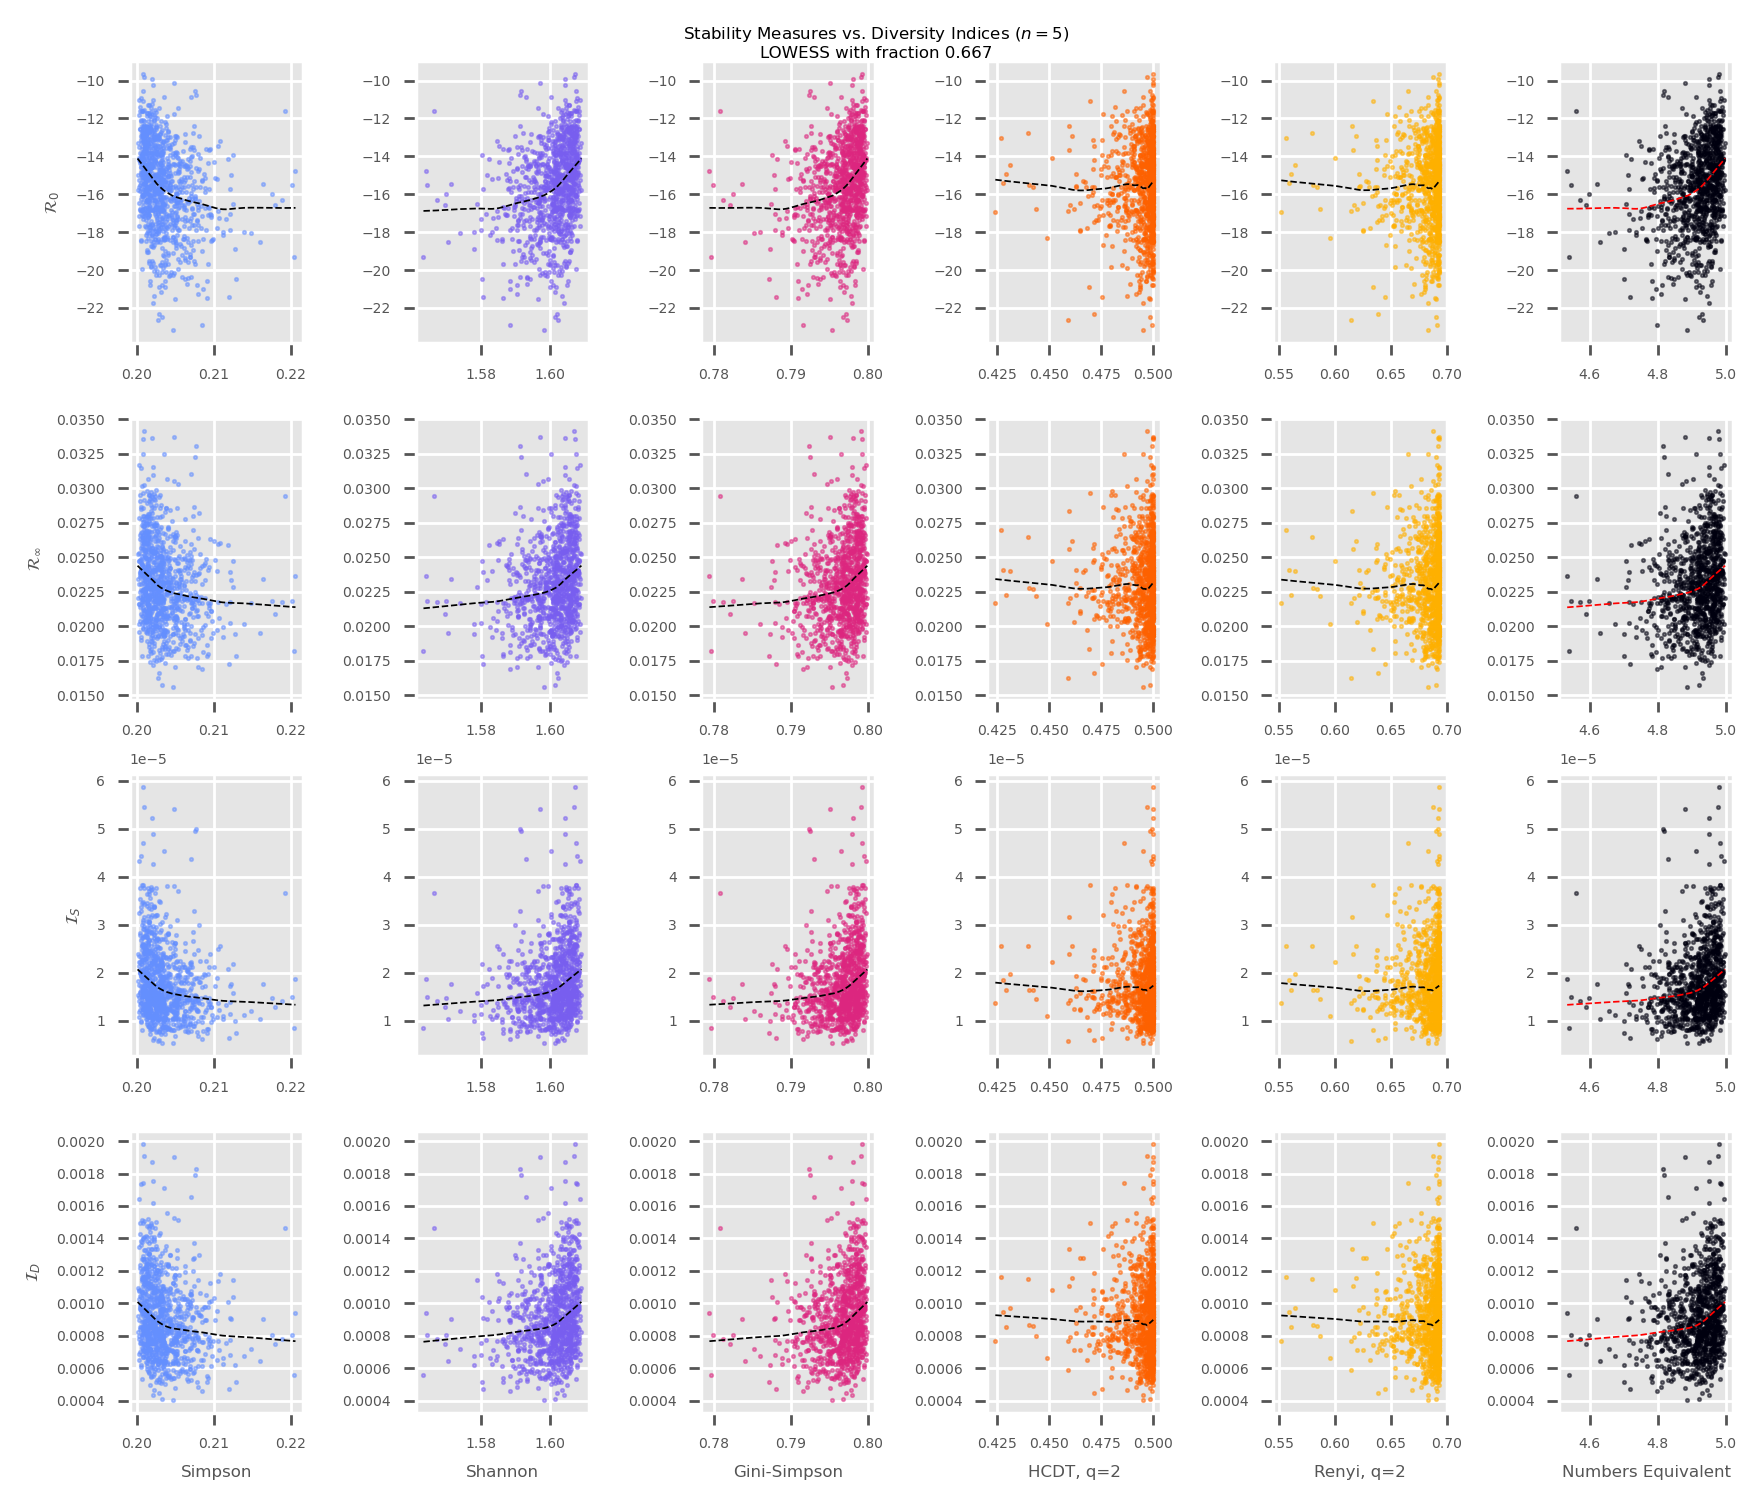

In [148]:
OD5.stab_div_plot(lowess_frac=2./3)

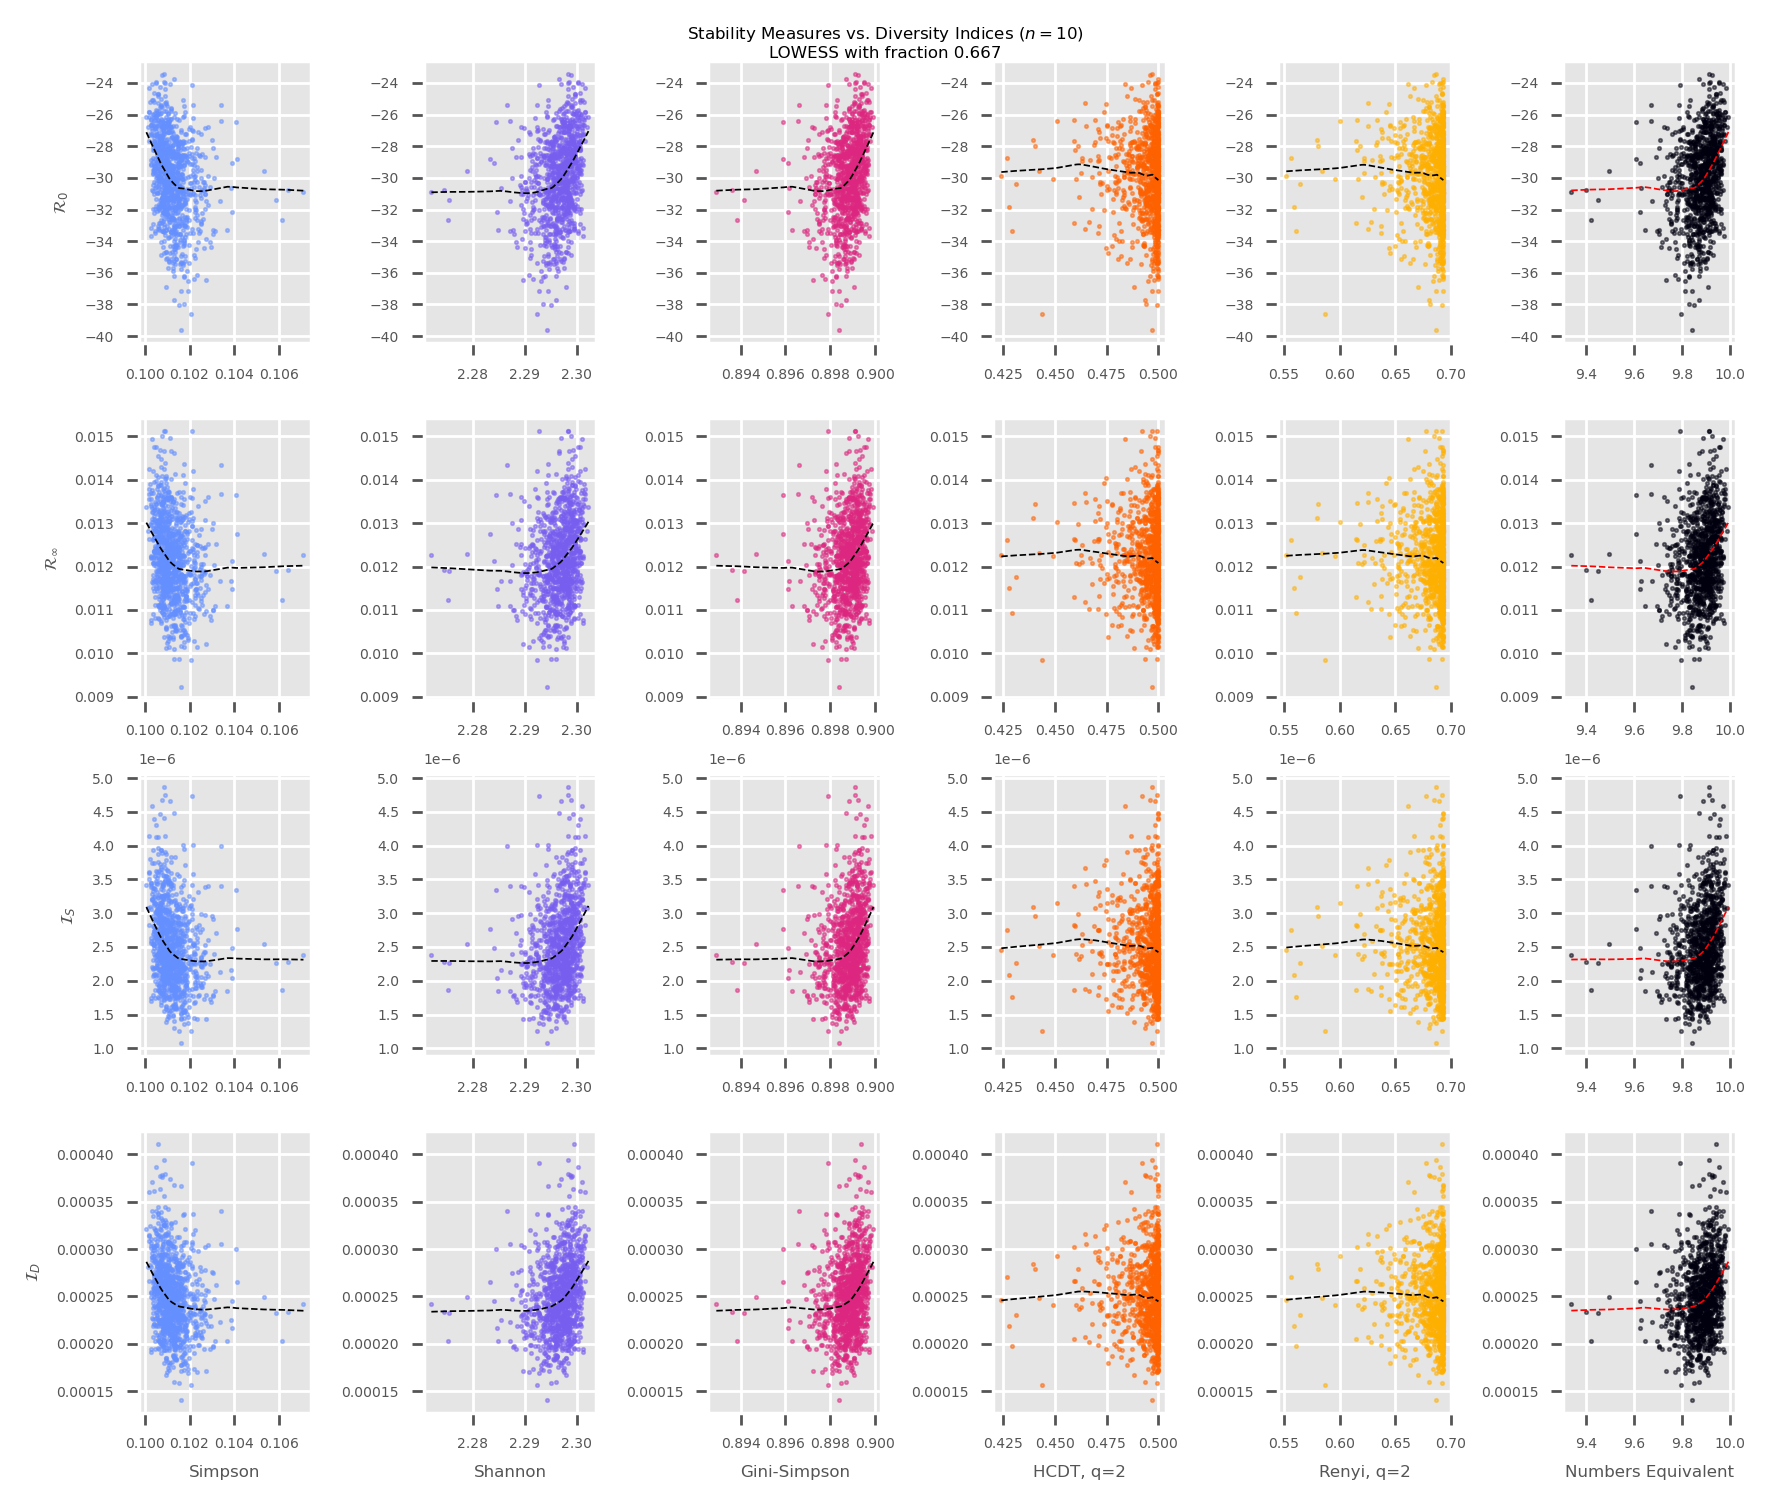

In [149]:
OD10.stab_div_plot(lowess_frac=2./3)

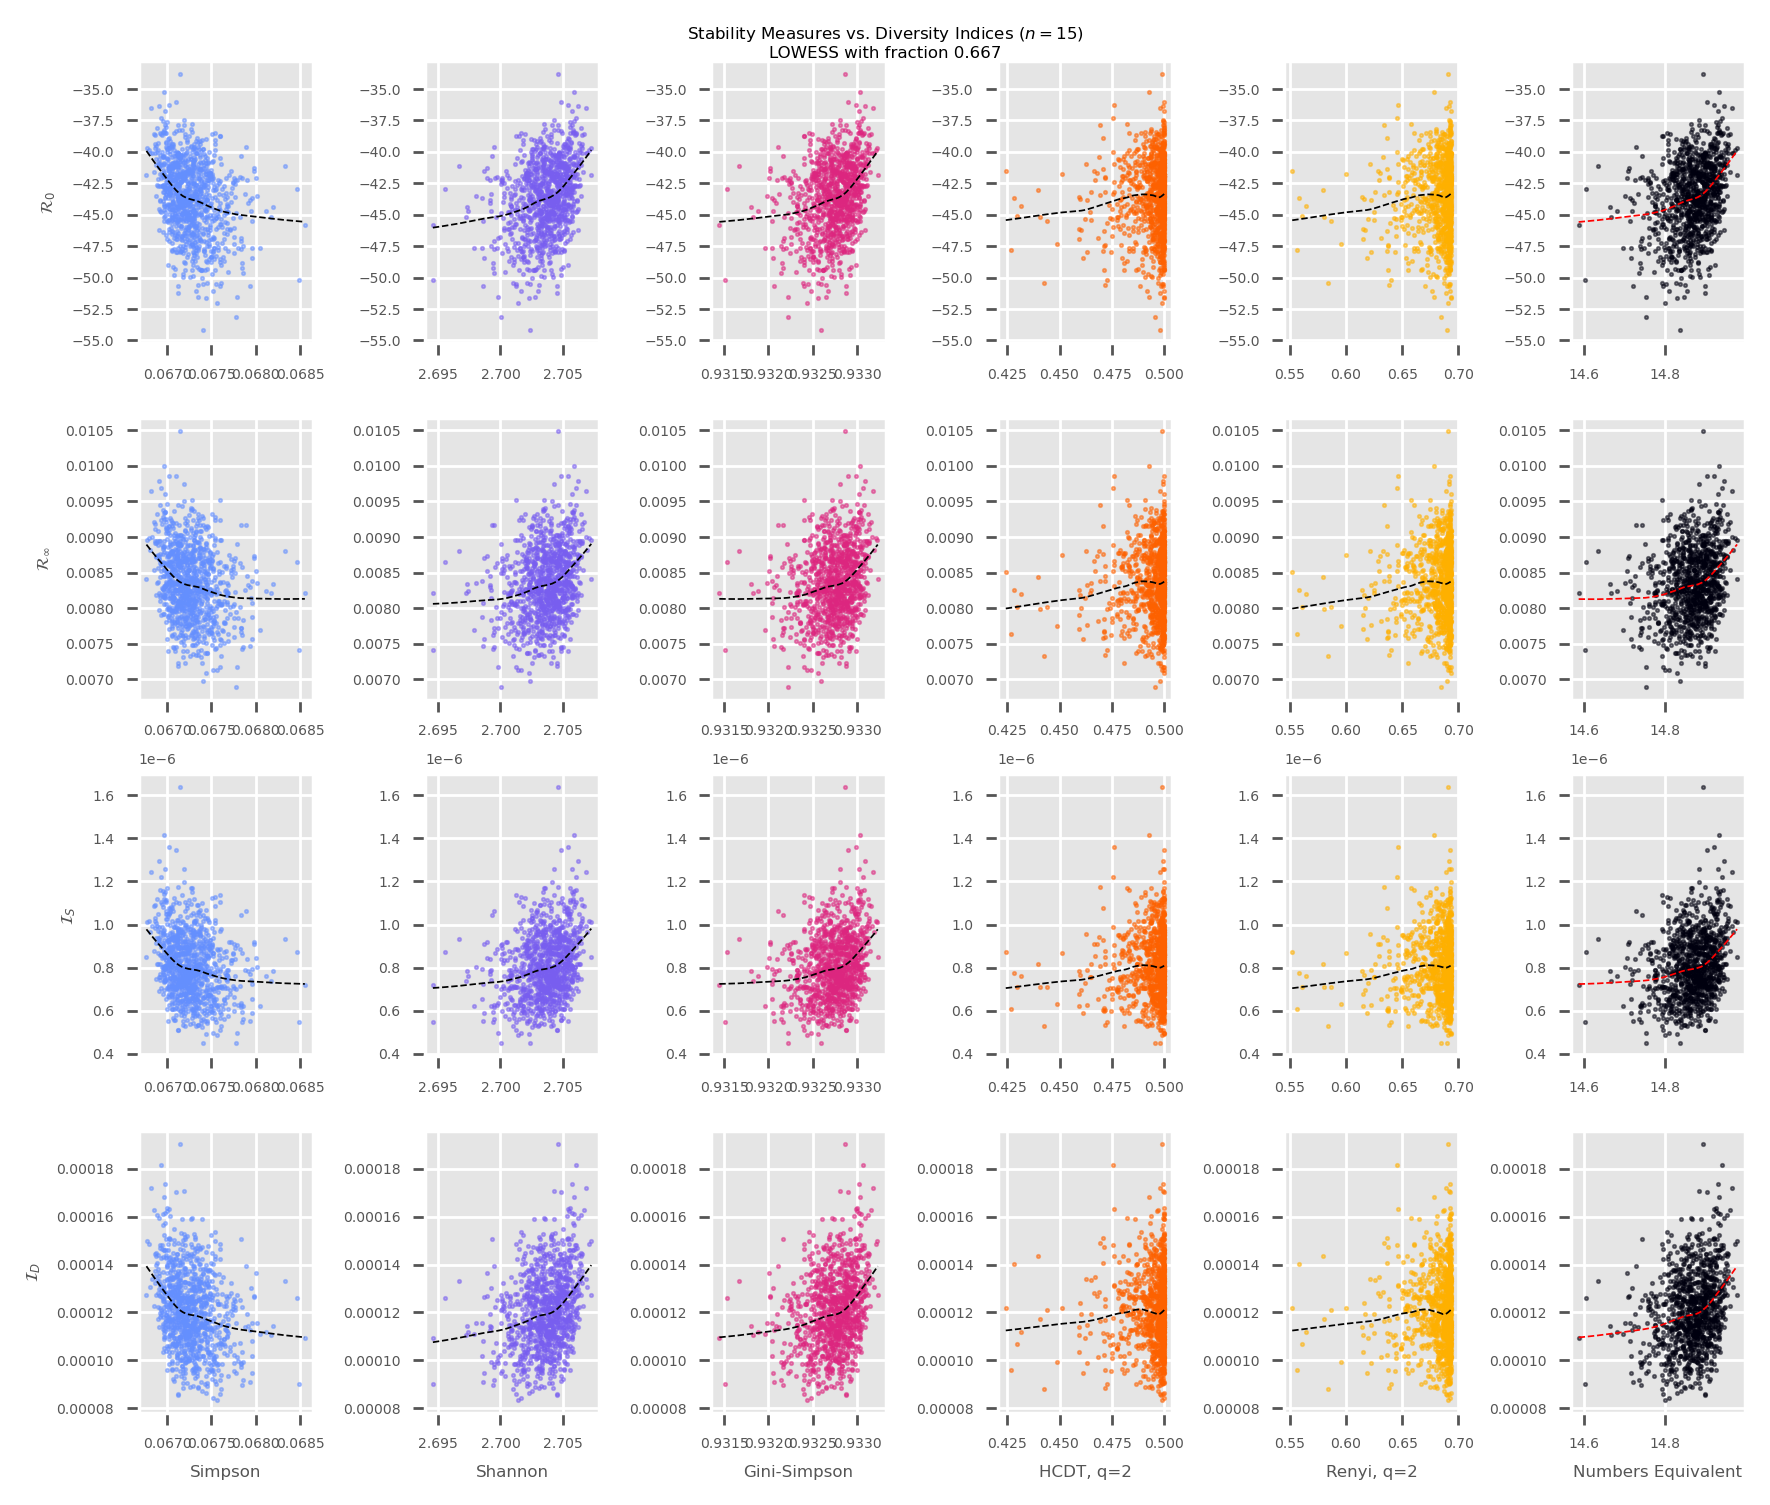

In [150]:
OD15.stab_div_plot(lowess_frac=2./3) # Fix the Simpson and Gini-Simpson columns' x-tick spacing

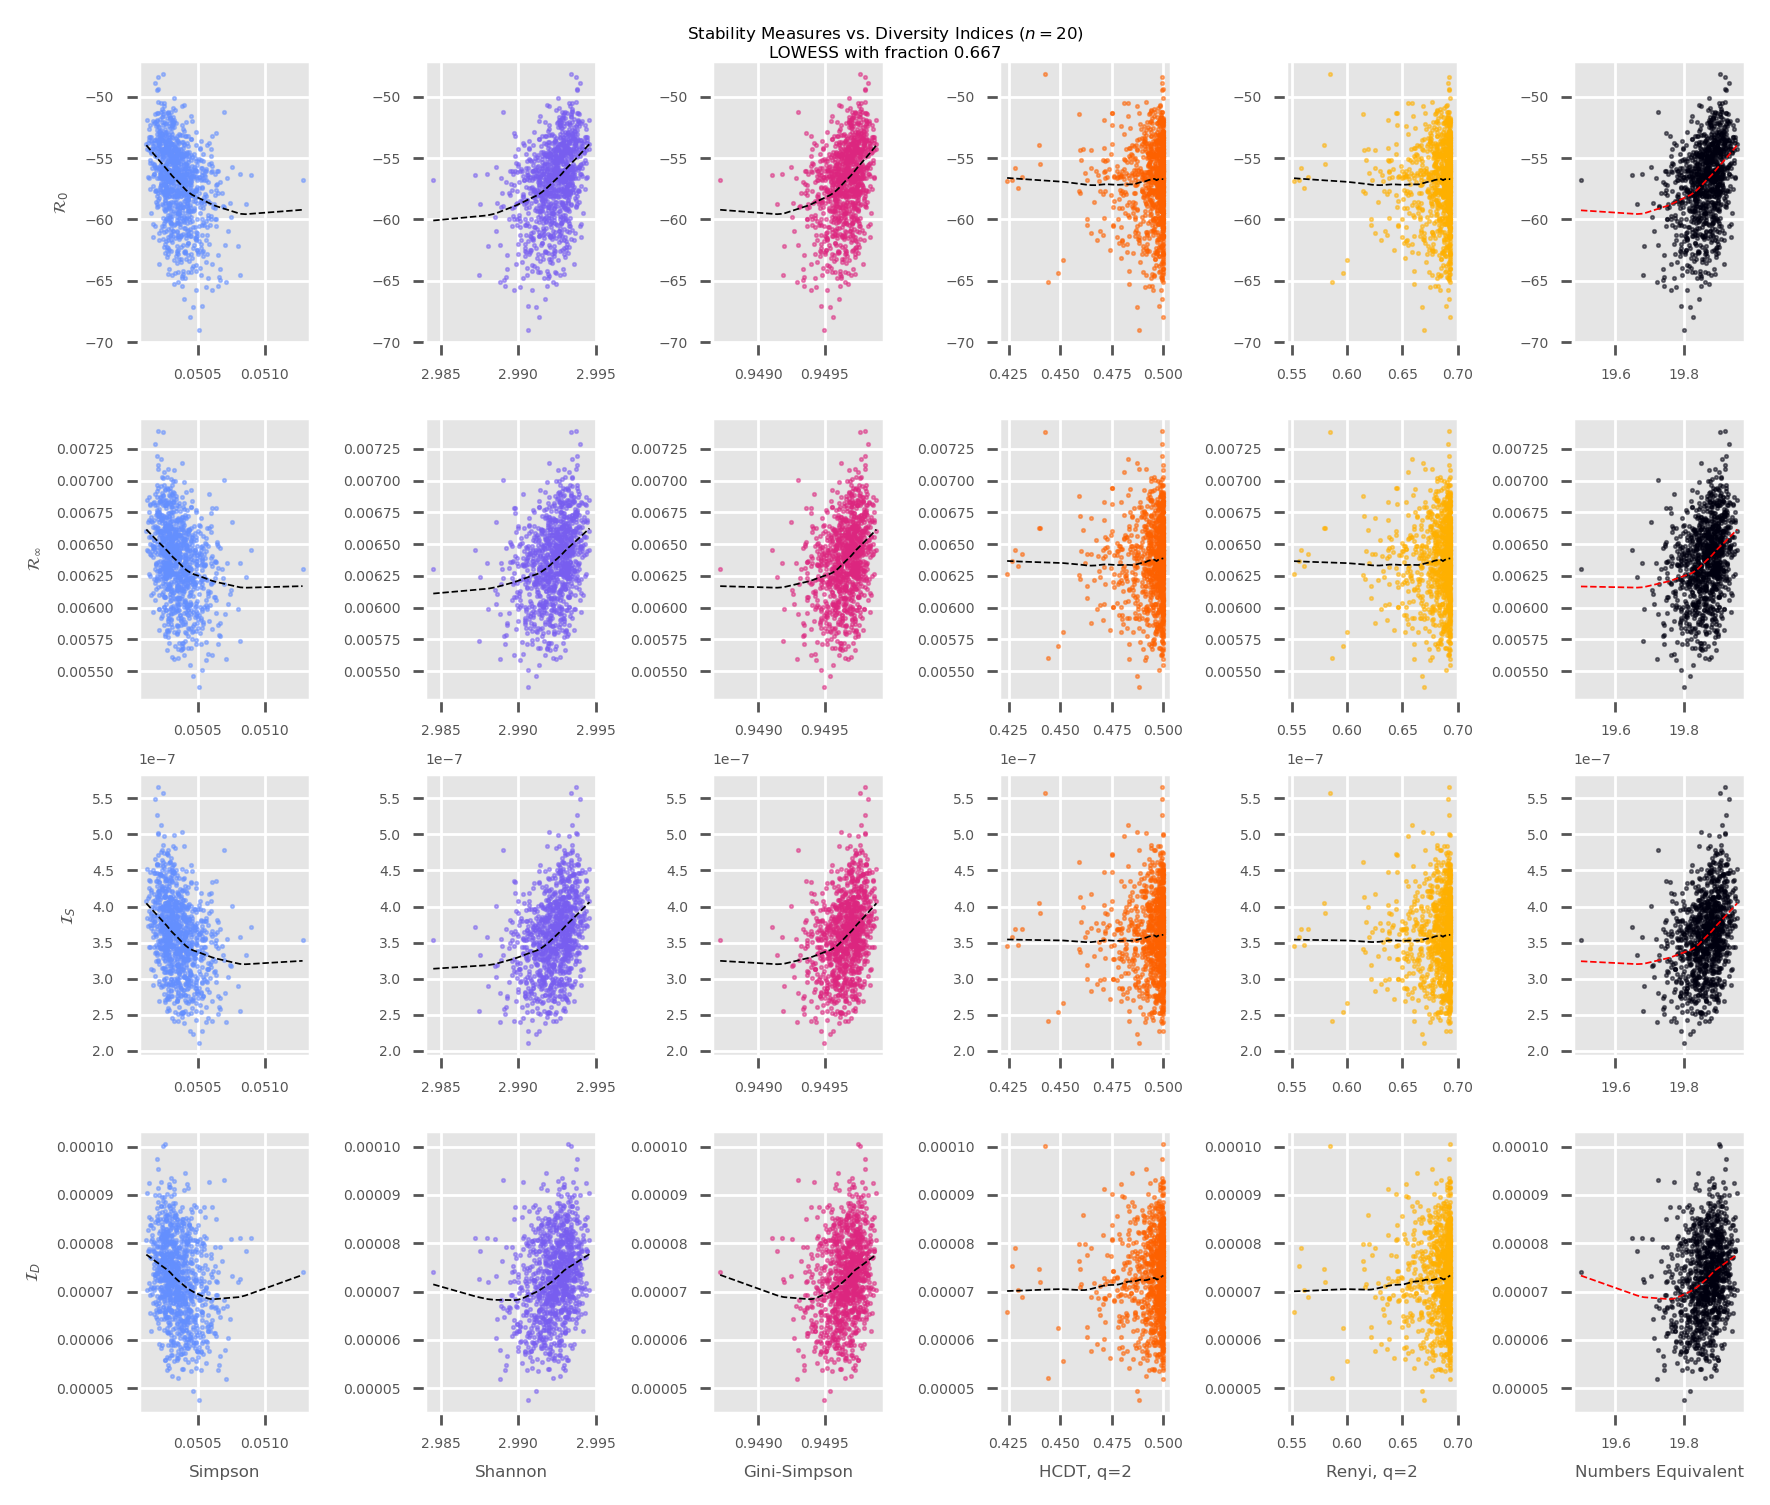

In [151]:
OD20.stab_div_plot(lowess_frac=2./3)

In [152]:
# Check out some summary stats between the system sizes
np.mean(OD2.R_0)
np.mean(OD3.R_0)
np.mean(OD5.R_0)
np.mean(OD10.R_0)
np.mean(OD15.R_0)
np.mean(OD20.R_0)

-6.291188929786284

-9.506394393403934

-15.60152503560543

-29.98134629478297

-43.62141350017188

-57.020345207288685

In [153]:
np.std(OD2.shannon_s)
np.std(OD3.shannon_s)
np.std(OD5.shannon_s)
np.std(OD10.shannon_s)
np.std(OD15.shannon_s)
np.std(OD20.shannon_s)

0.009941498870014638

0.009836899421304088

0.006828768332072678

0.003336325455702742

0.0017767202426854486

0.0012287349344706562

In [154]:
np.std(OD2.D_s)
np.std(OD3.D_s)
np.std(OD5.D_s)
np.std(OD10.D_s)
np.std(OD15.D_s)
np.std(OD20.D_s)

0.03609108514126844

0.055812387012564524

0.06795986088456167

0.06879740576873247

0.05431683944117856

0.05010683322395301

In [155]:
mean_eff_no_species = np.mean(np.array([OD2.D_s, OD3.D_s,OD5.D_s,OD10.D_s,OD15.D_s,OD20.D_s]), 1)

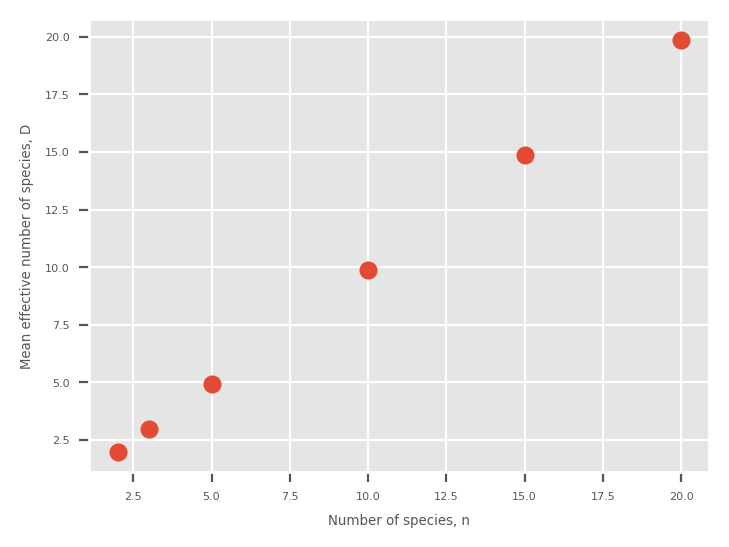

In [156]:
plt.figure(figsize=(4,3),dpi=200)
mpl.rcParams.update({'font.size': 4})
plt.scatter([2,3,5,10,15,20], mean_eff_no_species);
plt.ylabel('Mean effective number of species, D');
plt.xlabel('Number of species, n');
# Linear makes sense? Must be less than n but no less than n-1

In [157]:
# Mean difference between number of species and effective number of species

mean_diff = np.array([np.mean(OD2.n - OD2.D_s),
np.mean(OD3.n - OD3.D_s), 
np.mean(OD5.n - OD5.D_s), 
np.mean(OD10.n - OD10.D_s),
np.mean(OD15.n - OD15.D_s),
np.mean(OD20.n - OD20.D_s)])

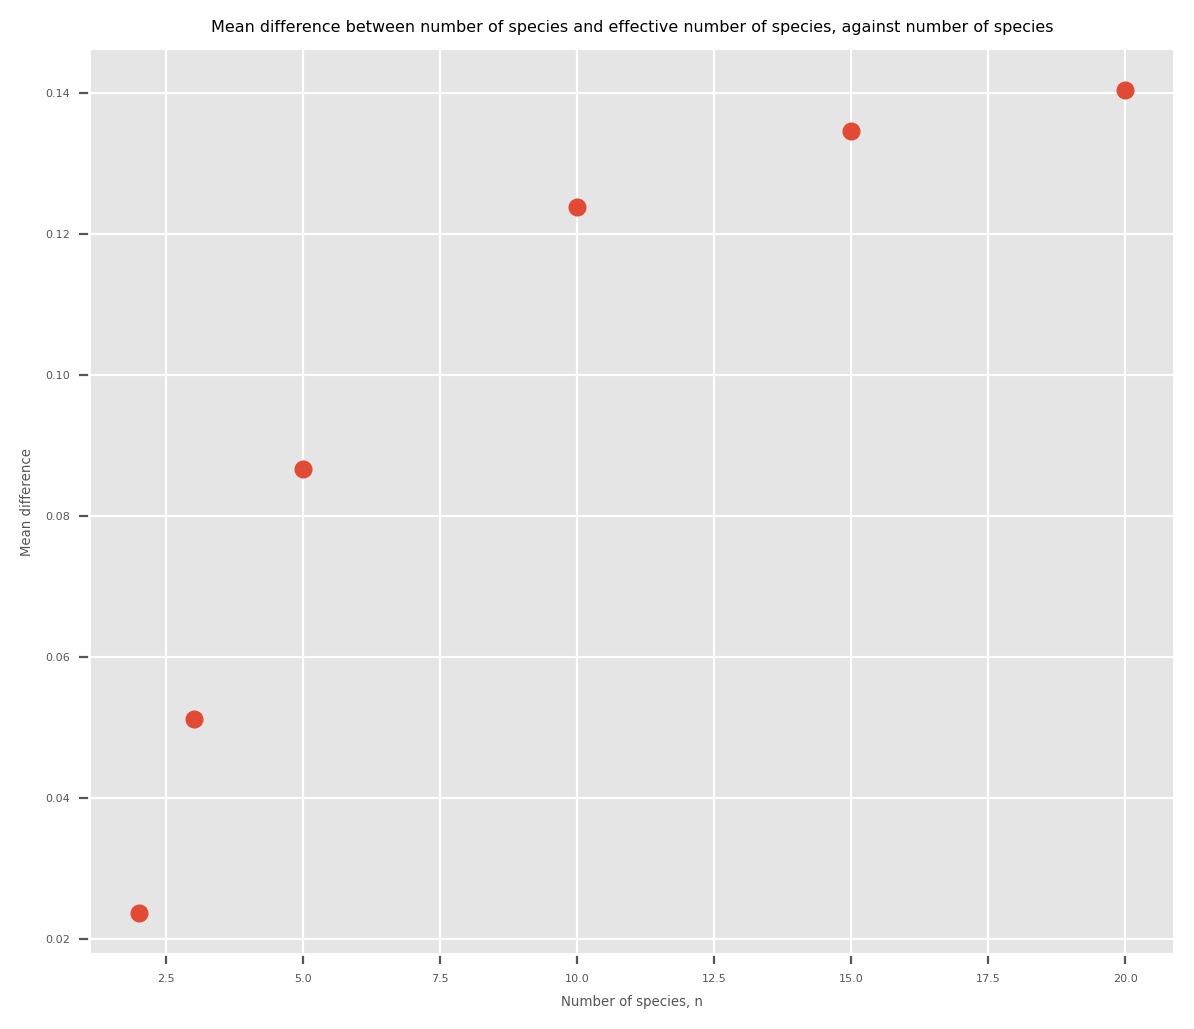

In [158]:
plt.figure(figsize=(7,6),dpi=200)
mpl.rcParams.update({'font.size': 4})
plt.scatter([2,3,5,10,15,20],mean_diff);
plt.title('Mean difference between number of species and effective number of species, against number of species');
plt.ylabel('Mean difference');
plt.xlabel('Number of species, n');
# Because the above graph is pretty convincingly linear (at least a good approximation?),
    # the below might be hyperbolic? (1/n ish?)
    # That implies that there is a horizontal asymptote (upper bound) on this mean 
        # difference. Wild guess, 0.5?

# O'Dwyer Artifacts (NOTE SECTION)

In [159]:
# Is it possible that the O'Dwyer model equilibria has some distribution that is affecting
# what the Stability vs. Diversity graphs look like?

Stability measures are functions of the community matrix eigenvalues.
Diversity measures are functions of (equilibrium) population distributions, which themselves are
functions of the (random) choice of parameters. The community matrix eigenvalues are also a function of the (random) choice of parameters (see the Jacobian formula for O'Dwyer model).

Additionally, as for the supposed complexity of the O'Dwyer formulas, finding the distribution of the equilbria amounts to finding the PDF of the sum of n IID half-normal random variables.

PDF for sum of 2 half-normals (wrong by factor of 2?):

$$ f_{|Z_1|+|Z_2|}(x) =  \frac{2\sqrt{2}}{\sqrt{\pi}}e^{-\frac{1}{2}x^2}\text{erf}(\frac{x}{\sqrt{2}})$$
$$ f_{|Z_1|+|Z_2|}(x) = \frac{4}{\pi}e^{-\frac{1}{2}x^2}\int_0^{\frac{x}{\sqrt{2}}}e^{-t^2}dt $$ #2 is wrong

# Generalized Lotka-Volterra

In [160]:
from scipy.linalg import solve as slv # For calculating equilibrium populations of gLV.

In [161]:
def lv_gen(k_, n_, sig_A, C_=1., diag_ = 'random', interaction_type_='random', is_sym_=False):
    ''' Symmetric system
    k, number of matrices
    n, number of species
    sig_A, standard deviation of interaction rates
    '''
    dinds = np.diag_indices(n_)
    A = np.random.normal(loc=0, scale=sig_A, size=(k_,n_,n_)) # 0 in the diagonal
    if diag_ == 'random':
        A[:,dinds[0],dinds[0]] = -np.abs(A[:,dinds[0],dinds[0]])
    elif diag_ == 'uniform':
        A[:,dinds[0],dinds[0]] = np.random.uniform(low=-1, high=0, size=(k_,n_))
    elif diag_ == -1:
        A[:,dinds[0],dinds[0]] = -1
    else:
        print('Invalid diagonal type, defaulting to negative half normal (random)')
        A[:,dinds[0],dinds[0]] = -np.abs(A[:,dinds[0],dinds[0]])
    
    if is_sym_:
        temp_ = np.triu(A, k=1)
        A = np.triu(A) + np.transpose(temp_, (0,2,1))
    
    if interaction_type_ == 'pred_prey':# For predator-prey-like opposite signs across diagonal
        # Will increase likelihood of endemic equ. stability? Only for closely related pred-prey pairs, though.
        A = np.triu(A) - np.abs(np.tril(A))*np.transpose(np.sign(np.triu(A,1)), (0,2,1))
    elif interaction_type_ == 'mutualism':
        Adiag = A[:,dinds[0],dinds[0]]
        A = np.abs(A)
        A[:,dinds[0],dinds[0]] = Adiag
    elif interaction_type_ == 'competition':
        Adiag = A[:,dinds[0],dinds[0]]
        A = -np.abs(A)
        A[:,dinds[0],dinds[0]] = Adiag
    elif interaction_type_ == 'random': # Just leave regular normal off-diag entries
        A = A
    else: # No Match case
        return "Invalid interaction type."
        
    # sample from bernoulli to replace entries in matrix of ones with 0
    connect = np.random.binomial(1, C_, (k_, n_, n_))
    connect[:,dinds[0],dinds[0]] = 1
    connect = np.triu(connect,k=1) + np.transpose(np.triu(connect), (0,2,1))
    A = A * connect

    return A

$$0=r_i N_i^* (1-\frac{N_i^*}{k_i}) + N_i^* \sum_{j=1, j\neq i}^n \beta_{i,j} N_j^* $$
Set gLV equations equal to 0 to obtain linear system that can be solved for non-extinction equilibrium (after cancelling one factor of $N_i^{*}$).

In [162]:
def lv_equilibrium(A_,r_):
    # Need to solve system -r_i = sum_over_j(beta_{i,j}*N_star_j)
    N_star = np.zeros((A_.shape[0], A_.shape[1], 1))
    for i in range(A_.shape[0]):
        N_star[i,:,:] = slv(a=A_[i,:,:], b=r_[i,:,:])
    
    return N_star

In [ ]:
def lv_Jacobian(A_, r_, N_=None):
    if A_.ndim<3:
        A_ = np.expand_dims(A_, 0)
    if r_.ndim<3:
        r_ = np.expand_dims(r_, 0)
    if N_.ndim<3:
        N_ = np.expand_dims(N_, 0)
    k_ = A_.shape[0]
    n_ = A_.shape[1]
    
    if np.any(N_==None):
        N_star_ = lv_equilibrium(A_,r_)
    else:
        N_star_ = N_
        
    D_ = np.eye(n_) * r_.reshape(k_,n_,1)
    
    # Dotting k_ matrices with k_ vectors
    dinds_k = np.diag_indices(k_)[0]
    dot = np.dot(A_, N_star_.reshape(k_,n_,1))[dinds_k,:,dinds_k,:]
    D_ = D_ + np.eye(n_)*dot
    
    # There is an extra beta_{i,i}*N_i in each diag entry
    dinds_n = np.diag_indices(n_)[0]
    D_[:,dinds_n,dinds_n] = D_[:,dinds_n,dinds_n] + A_[:,dinds_n,dinds_n]*N_star_.reshape(k_,n_)
    
    # Off-diagonal entries
    temp_ = A_*N_star_.reshape(k_,1,n_)
    temp_[:,dinds_n,dinds_n] = 0
    
    D_ = D_ + temp_
    
    return D_

### LV Class

In [ ]:
class LVsystem: # MUST CAST OUT UNSTABLE SYSTEMS!!! or just choose params better
    '''
    Lotka-Volterra systems + their community matrices and equilibria + Arnoldi Measures.
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species
    r, vector of intrinsic birth rates
    sig_A, standard deviation of entries in interaction matrix A
    C, connectance (as in May), probability that a pair of species interact,
                meaning non-zero a_ij and a_ji
    diag, either -1 or 'random', main diagonal entries of A
    interaction_type, type of A (interaction) matrix entries
                -'pred_prey': sign(a_ij) = -1 * sign(a_ji)
                -'mutualism': sign(a_ij) = sign(a_ji) = (+)
                -'random': no change
                -'competition': sign(a_ij) = sign(a_ji) = (-)
    is_sym, |a_ij|=|a_ji|
    '''
    def __init__(self, k_=1000,n_=5, r_=None, sig_A_=1, C_=1., diag_='random', interaction_type_='pred_prey', is_sym_=False):
        # Add list:
            # Replace pred_prey with interaction_type string parameter (pred_prey, mutual, competition, mixture)
            # Double check the units/magnitudes/funny business on O'Dwyer values (equilbria are crazy)
            # Use May/Allesina complexity bounds to check what is wrong with gLV community matrices.
        self.k = k_
        self.n = n_
        self.C = C_
        self.sig_A = sig_A_
        self.diag = diag_
        self.interaction_type = interaction_type_
        self.is_sym = is_sym_

        if r_ is None:
            self.r = np.random.uniform(0,1,(self.k,self.n,1))
        else:
            self.r = r_
       
        self.A = lv_gen(self.k, self.n, self.sig_A, self.C, diag_=self.diag, interaction_type_ = self.interaction_type, is_sym_=self.is_sym)
        
        self.J = lv_Jacobian(self.A, self.r)
        
        self.N_star = lv_equilibrium(self.A, self.r).reshape(self.k,self.n,1)

        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measures ###
        self.n_star = sum_to_one(self.N_star)

        self.simpson = simpson_conc(self.n_star)
        self.shannon = shannon_entropy(self.n_star)
        self.gini_simp = gini_simpson_index(self.n_star)
        self.hcdt_entropy = hcdt_entropy(self.n_star, q=2)
        self.renyi_entropy = renyi_entropy(self.n_star, q=2)
        self.D = 1/(1-self.gini_simp)
        
        # DON'T have working stable gLV systems yet, so can't do stability-diversity plots.
#     def stab_div_plot(self, fsize=(7,6), res = 250, fontsize=4, q=2, lowess_frac=None):
#         q_renyi=q
#         q_hcdt=q
#         # q_renyi = int(input('q (order of diversity) for Renyi entropy?'))
#         # q_hcdt = int(input('q for HCDT entropy?'))
#         hcdt = hcdt_entropy(self.n_star, q=q_hcdt)
#         renyi = renyi_entropy(self.n_star, q=q_renyi)
                
#         xlist = [self.simpson, self.shannon, self.gini_simp, hcdt, renyi, self.D]
#         xnames = ['Simpson', 'Shannon', 'Gini-Simpson', r'HCDT, q={}'.format(q_hcdt), 'Renyi, q={}'.format(q_renyi), 'Numbers Equivalent']
#         ylist = [self.R_0, self.R_inf, self.I_S, self.I_D]
#         ynames = [r'$\mathcal{R}_0$', r'$\mathcal{R}_{\infty}$', r'$\mathcal{I}_S$', r'$\mathcal{I}_D$']
        
#         plt.figure(figsize=fsize, dpi=res)
#         plt.style.use('ggplot')
#         mpl.rcParams.update({'font.size': fontsize})
#         thetitle = 'gLV Stability Measures vs. Diversity Indices ($n=${})'.format(self.n)
#         if lowess_frac:
#             thetitle = thetitle + '\nLOWESS with fraction {}'.format(np.round(lowess_frac,3))
#         plt.suptitle(thetitle);

        
#         colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#000000']
        
#         dimx = len(xlist)
#         dimy = len(ylist)
        
#         for i,stab in enumerate(ylist):
#             for j,divind in enumerate(xlist):
#                 plt.subplot(4,6,i*dimx+j+1)
#                 plt.scatter(divind, stab, s = 1, alpha=0.5, color = colors[j%dimx]);
#                 if lowess_frac:
#                     w = lowess(stab.reshape(-1), divind.reshape(-1), frac=lowess_frac)
#                     if j != 5:
#                         plt.plot(w[:,0], w[:,1], c='black', linestyle='dashed', linewidth=0.5, alpha=1.00)
#                     else:
#                         plt.plot(w[:,0], w[:,1], c='red', linestyle='dashed', linewidth=0.5, alpha=1.00)
#                 if j%dimx == 0:
#                     plt.ylabel(ynames[i]);
#                 if i == dimy-1:
#                     plt.xlabel(xnames[j]);

#         plt.tight_layout();    

In [ ]:
# np.random.seed(667)
# # Try a bunch of different systems; certain interaction types should be more likely to be stable given a sigma_A,
# # connectance C, and number of species S.

# LV5_comp = LVsystem(1000,5, sig_A_ = 0.05, C_= 0.75, diag_='uniform', interaction_type_='competition')

# LV5_mut = LVsystem(1000,5, sig_A_ = 0.25, C_= 0.25, interaction_type_='mutualism')

# LV2_mut = LVsystem(1000,2, sig_A_ = 0.25, C_= 0.25, interaction_type_='mutualism')

# LV2_mut_sym = LVsystem(1000,2, sig_A_ = 0.25, C_= 0.25, interaction_type_='mutualism', is_sym_=True)

# LV2_rand = LVsystem(1000,2, sig_A_ = 0.25, C_= 0.25, interaction_type_='random')

# LV2_pp = LVsystem(1000,2, sig_A_ = 0.25, C_= 1., interaction_type_='pred_prey')

# LV2_pp_sym = LVsystem(1000,2, sig_A_ = 0.25, C_= 1., interaction_type_='pred_prey', is_sym_=True)

In [ ]:
# Find May 'complexity' of these gLV communities
# sigma * sqrt(S*C) # S, number species; C, connectance
# NOTE: Need the standard deviation (sigma) of the entries of the Jacobian J, not of interaction matrix A

def may_complexity(sig_, S_, C_):
    return sig_ * np.sqrt(S_*C_)

# heliparv / generalized_Lotka-Volterra 
Numerical gLV library. Parameters are found in parameters.py. Apparent stability of non-extinction equilibrium is just numeric cheating.

<https://github.com/heliparv/generalized_Lotka-Volterra>

In [ ]:
# import sys
# sys.path.insert(0, r'Your\Path\to\This\File\generalized_Lotka-Volterra')

Standard gLV (meaning with carrying capacity and only pairwise mass action terms)
Community matrix takes the form:
$$
r_i - N_i^* + \sum\limits_{j=1}^{n} \beta_{i,j}N_{j}^{*} \quad \text{for}\space i=j
\\
\beta_{i,j}N_j^* \quad \text{for}\space i\neq j
$$

In [ ]:
# plt.figure(figsize=(7,6),dpi=250);
# plt.style.use('ggplot');
mpl.rcParams.update({'font.size': 12});
# %run E:\Progrumping\Microbiome\generalized_Lotka-Volterra\index_gLVwK.py

In [ ]:
import numpy as np
import pandas as pd
from parameters import add_sparcity, generate_growth_rates, generate_interactions, generate_starting_abundances, adjust_selfinteractions, calculate_carrying_capacities
from simulations_gLVwK import only_viable_gLVwK, gLVwK_with_extinction, test_gLVwK
from graphics import abundances_line_chart, interactions_heatmap
import random


#Number of species
n = 10
#Maximum simulation time
maxtime = 50
total_carrying_capacity = 20000000

ri = generate_growth_rates(n, 0.5, seed_growth=12,std=0.1)

starting_abundances = generate_starting_abundances(n,seed_abundance=12, mean=100, std=0.1)

pairwise_interactions = generate_interactions(n, 1, seed_interactions=2, mean=0, std=0.001) # std=0.001
# How does std as a fraction of mean work when mean is just 0????? Bad?
# seed_interactions=12
pairwise_interactions = add_sparcity(pairwise_interactions, 0.3, seed_sparcity=12) # Sparcity 0.3

pairwise_interactions = adjust_selfinteractions(n, pairwise_interactions,seed_selfinter=12, mean=-0.001, std=0.1) # std 0.1

carrying_capacities = calculate_carrying_capacities(ri, pairwise_interactions)

abundances = gLVwK_with_extinction(n, maxtime, pairwise_interactions, ri, carrying_capacities, starting_abundances, total_carrying_capacity)

In [ ]:
abundances[-1,:]

In [ ]:
# pairwise_interactions

In [ ]:
jacobian = lv_Jacobian(A_=pairwise_interactions, r_=ri, N_=abundances[-1,:])

In [ ]:
np.expand_dims(ri,(0,1)).shape

In [ ]:
lv_equilibrium(np.expand_dims(pairwise_interactions,0), np.expand_dims(ri,(0,1)).reshape(1,-1,1))

In [ ]:
eigvals(jacobian).real

In [ ]:
np.any(None==None)